In [1]:
# Copyright 2011-2019 Kwant authors.
#
# This file is part of Kwant.  It is subject to the license terms in the file
# LICENSE.rst found in the top-level directory of this distribution and at
# http://kwant-project.org/license.  A list of Kwant authors can be found in
# the file AUTHORS.rst at the top-level directory of this distribution and at
# http://kwant-project.org/authors.

from packaging import version

import numpy as np
import scipy.linalg
import scipy.optimize
import scipy.sparse as sp

__all__ = ["find_boundstates"]

# TODO: remove this when we depend on scipy > 1.1
#1.3.1 here
if version.parse(scipy.__version__) > version.parse("1.1"):
    null_space = scipy.linalg.null_space
else:

    def null_space(A, rcond=None):
        u, s, vh = scipy.linalg.svd(A, full_matrices=True)
        M, N = u.shape[0], vh.shape[1]
        if rcond is None:
            rcond = np.finfo(s.dtype).eps * max(M, N)
        tol = np.amax(s) * rcond
        num = np.sum(s > tol, dtype=int)
        Q = vh[num:, :].T.conj()
        return Q


# If available, use MUMPS support for shift-inverse sparse diagonalization
# Can import mumps alright.
try:
    from kwant.linalg import mumps
except ImportError:
    sparse_diag = sp.linalg.eigsh
else:

    class _LuInv(sp.linalg.LinearOperator):
        def __init__(self, A):
            inst = mumps.MUMPSContext()
            inst.analyze(A)
            inst.factor(A)
            self.solve = inst.solve
            super().__init__(A.dtype, A.shape)

        def _matvec(self, x):
            return self.solve(x.astype(self.dtype))

    def sparse_diag(matrix, k, sigma, **kwargs):
        if sigma == 0:
            shifted_matrix = matrix
        else:
            shifted_matrix = matrix - sigma * sp.identity(matrix.shape[0])
        return sp.linalg.eigsh(matrix, k, sigma=sigma, OPinv=_LuInv(shifted_matrix),
                               **kwargs)

"""syst: kwant.system.FiniteSystem
"""

def find_boundstates(
    syst,
    min_energy,
    max_energy,
    params=None,
    sparse=True,
    check_hermiticity=True,
    rtol=1e-3,
):
    """Return boundstates of an open system in an energy window

    Parameters
    ----------
    syst : kwant.system.FiniteSystem
        Must have leads.
    min_energy, max_energy : float
        The lower and upper bounds in energy to search for boundstates.
    params : dict, optional
        The keyword arguments to 'syst'.
    sparse : bool, default: True
        If True use sparse linear algebra, otherwise use dense.
    check_hermiticity : bool, default: True
        If True, checks the Hermiticity of the system Hamiltonian
    rtol : float, default: 1E-3
        boundstates that are closer together than
        'rtol * (max_energy - min_energy)' may be missed.

    Returns
    -------
    energies : 1D float array
        The energies of the bound states.
    wavefunctions : 2D complex array
        The columns are the bound state wavefunctions defined
        over the scattering region.
    """

    # TODO: apply lru_cache to this once
    # https://github.com/scipy/scipy/issues/10846 is solved.
    def min_eigenvalue(energy):
        H_eff = make_linsys(
            syst,
            energy,
            params=params,
            sparse=sparse,
            check_hermiticity=check_hermiticity,
        )
        try:
            if sparse:
                if H_eff.shape[0] <= 2:
                    raise ValueError(
                        "The system is too small to use sparse diagonalization. "
                        "Try setting 'sparse=False'."
                    )
                vals = sparse_diag(
                    H_eff.tocsc(), k=1, sigma=1e-10, which="LM", return_eigenvectors=False
                )
                '''print('energy:')
                print(energy)
                print('Direct Diagonalisation:')
                print(spi.linalg.eigvals(H_eff.toarray()))
                print('sparce f:')
                print(vals[np.argmin(np.abs(vals))]'''
                return vals[0]
            else:
                vals = np.linalg.eigvalsh(H_eff)
                which = np.argmin(np.abs(vals))
                return vals[which]
        except RuntimeError:  # Some problem diagonalizing
            return np.inf

    if syst.site_ranges is not None:
        tot_norbs = syst.site_ranges[-1][-1]
    else:
        _, norbs = syst.hamiltonian_submatrix(params=params, return_norb=True)[:2]
        tot_norbs = sum(norbs)

    # Grid the energy window and search for roots in the sub-windows
    # where the min-eigenvalue changes sign. These will either be
    # true roots or discontinuities. Note that if there are >1 roots
    # in the same sub-window then at least one of them will be missed.
    '''print('f(0):')
    print(min_eigenvalue(0))
    print('f(1e-16)')
    print(min_eigenvalue(1e-16))
    print('f(3e-16)')
    print(min_eigenvalue(3e-16))
    print('f(1e-15)')
    print(min_eigenvalue(1e-15))'''
    
    '''print('f(0):')
    print(min_eigenvalue(0.))'''
    
    energies = np.linspace(
        min_energy, max_energy, int((max_energy - min_energy) / rtol)
    )
    intervals = zip(energies, energies[1:])
    candidates = []
    for a, b in intervals:
        try:
            if np.sign(min_eigenvalue(a)) != np.sign(min_eigenvalue(b)):
                candidate = scipy.optimize.brentq(min_eigenvalue, a, b)
                candidates.append(candidate)
        except RuntimeError: #some problems with lead modes
            continue
    
    '''f_E = []
    for e in energies:
        f_E.append(min_eigenvalue(e))
    plt.scatter(energies, f_E)'''
    
    # Check which candidate points give actual boundstates.
    energies = []
    states = []
    for energy in candidates:
        print('energy=')
        print(energy)
        vecs = extract_boundstates(syst, energy, params=params, sparse=sparse)
        # vecs.shape[1] == 0 if there were no boundstates found
        energies.append([energy] * vecs.shape[1])
        # Here we discard the mode part of the solution just to
        # make the output format more uniform (wavefunction has
        # same number of components at all energies).
        states.append(vecs[:tot_norbs, :])
        print('vecs')
        print(vecs)
        
    print('states')
    print(states)

    if not energies:
        return np.empty((0,)), np.empty((tot_norbs, 0))
    else:
        return np.hstack(energies), np.hstack(states)


def extract_boundstates(
    syst, energy=0, params=None, sparse=True, check_hermiticity=True, tol=1e-8
):
    """Return any true boundstates of 'syst' at 'energy'

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity

    Returns
    -------
    vecs : 2D array
        The columns are bound state wavefunctions.
        The first N rows is in the tight-binding basis of the
        scattering region, and the remaining rows are in the
        basis of stabilized evanescent modes of the leads.

    Notes
    -----
    We diagonalize the linear system returned by 'make_linsys', and
    search for zero eigenvalues. We then look for vectors in the basis
    of zero-eigenvalue eigenvectors that satisfy the bound state condition,
    eq. 19 of https://doi.org/10.21468/SciPostPhys.4.5.026.
    """

    lhs, T = make_linsys(
        syst,
        energy,
        params=params,
        sparse=sparse,
        check_hermiticity=check_hermiticity,
        return_validation=True,
        which="hermitian",
    )

    if sparse:
        if lhs.shape[0] <= 2:
            raise ValueError(
                "The system is too small to use sparse diagonalization. "
                "Try setting 'sparse=False'."
            )
        k = min(6, lhs.shape[0] - 2)  # 6 is the default for sp.linalg.eigsh
        try_again = True
        # Solve the eigenproblem with successively large values of 'k' until
        # we get all the zero eigenvalues. (In most cases this loop will
        # run once).
        while try_again:
            vals, vecs = sparse_diag(lhs.tocsc(), k=k, sigma=1e-10, which="LM")
            zeros = np.abs(vals) < tol  # TODO: make this check better
            if not np.all(zeros):  # we have found all the zero eigenvalues
                try_again = False
            else:
                k *= 2  # try again with twice the number of eigenvalues
                if k >= lhs.shape[0] - 1:
                    raise ValueError(
                        "More eigenvalues are 0 than can be obtained by "
                        "sparse diagonalization. Try setting 'sparse=False'."
                    )
    else:
        vals, vecs = np.linalg.eigh(lhs)
        zeros = np.abs(vals) < tol  # TODO make this check better

    if not np.any(zeros):
        return np.empty((lhs.shape[0], 0))


    zero_vecs = vecs[:, zeros]
    # To find the true boundstates we find the null space of the operator
    # in eq 19 (T) in the basis of zero-eigenvalue vectors.
    p = T @ zero_vecs
    if np.allclose(p, 0):
        # 'zero_vecs' are already a basis for the null space of T
        return zero_vecs
    else:
        # TODO: not sure about this value for 'rcond', we need to ensure
        #       that rcond is sufficiently large in the case that p is
        #       zero (i.e. zero_vecs are individually boundstates).
        bound_states = null_space(p, rcond=tol / np.max(np.abs(p)))
        # transform back to original basis
        # TODO: rotate the basis so the bound states have the correct symmetries
        return np.asarray(zero_vecs @ bound_states)


def make_linsys(
    syst,
    energy=0,
    params=None,
    sparse=True,
    check_hermiticity=True,
    return_validation=False,
    which="hermitian",
):
    """Return the linear system for finding boundstates

    Returns ether the linear system defined in equation 12 or equation 11
    of https://doi.org/10.21468/SciPostPhys.4.5.026, and the linear
    operator defined in equation 19 of the same article.

    Params
    ------
    syst : kwant.FiniteSystem
        Must have leads
    energy : float
    params : dict, optional
        Keyword arguments to 'syst'
    sparse : bool, default: True
        If True, returns sparse matrices
    check_hermiticity : bool, default: True
        If True, check the system Hamiltonian for hermiticity
    return_validation: bool, default: False
        If True, also return the linear operator used for
        checking for true bound states (equation 19 of the article).
    which : str, default: "hermitian"
        Which linear system to return. If "hermitian" returns the
        linear system defined in equation 12, if "svd" returns
        the linear system defined in equation 11.

    Returns
    -------
    lhs : 2D array or sparse matrix
        The linear system for finding boundstates
    T : 2D array or sparse matrix
        A linear operator for checking bound states.
        zero-eigenvalue eigenvectors of 'lhs' that are in the
        null-space of 'T' are true bound states. Only returned
        if 'return_validation' is True.
    """
    if not syst.leads:
        raise ValueError("'syst' must have leads attached")
    if any(interface.shape[0] == 0 for interface in syst.lead_interfaces):
        raise ValueError(
            "All the leads of 'syst' must have non-zero " "inter-cell hopping"
        )

    lhs, norb = syst.hamiltonian_submatrix(
        params=params, sparse=sparse, return_norb=True
    )[:2]
    offsets = np.empty(norb.shape[0] + 1, int)
    offsets[0] = 0
    offsets[1:] = np.cumsum(norb)
    scattering_region_norbs = offsets[-1]

    if check_hermiticity and len(lhs.data):
        rtol = 1e-13
        atol = 1e-300
        tol = rtol * np.max(np.abs(lhs.data)) + atol
        if np.any(np.abs((lhs - lhs.T.conj()).data) > tol):
            raise ValueError(
                "System Hamiltonian is not Hermitian. "
                "Use option `check_hermiticity=False` "
                "if this is intentional."
            )

    if sparse:
        lhs = lhs - energy * sp.identity(lhs.shape[0])
    else:
        lhs.flat[:: (offsets[-1] + 1)] -= energy

    phi_e = []
    svd_vs = []
    transfs = []
    for leadnum, interface in enumerate(syst.lead_interfaces):
        lead = syst.leads[leadnum]
        _, stab = lead.modes(energy, params=params)
        svd_v = stab.sqrt_hop
        # Evanescent modes (schur vectors) are stored after
        # the 2*nmodes propagating (in/out) modes
        evan_vecs = slice(2 * stab.nmodes, None)
        u_out = stab.vecs[:, evan_vecs]
        ulinv_out = stab.vecslmbdainv[:, evan_vecs]

        # Construct a matrix of 1's that translates the
        # inter-cell hopping to a proper hopping
        # from the system to the lead.
        iface_orbs = np.r_[tuple(slice(offsets[i], offsets[i + 1]) for i in interface)]

        n_lead_orbs = svd_v.shape[0]
        if n_lead_orbs != len(iface_orbs):
            msg = (
                "Lead {0} has hopping with dimensions "
                "incompatible with its interface dimension."
            )
            raise ValueError(msg.format(leadnum))

        coords = np.r_[[np.arange(len(iface_orbs))], [iface_orbs]]
        transf = sp.csc_matrix(
            (np.ones(len(iface_orbs)), coords), shape=(iface_orbs.size, lhs.shape[0])
        )

        phi_e.append(ulinv_out)
        svd_vs.append(svd_v)
        # We are saving these for use in '_validation_operator', where we
        # expect each projector to project *from the scattering region only*,
        # hence the slice up to 'scattering_region_norbs'
        transfs.append(transf[:, :scattering_region_norbs])

        if which == "hermitian":
            A, B, C = _hermitian_matrices(svd_v, transf, u_out, ulinv_out)
        elif which == "svd":
            A, B, C = _svd_matrices(svd_v, transf, u_out, ulinv_out)
        else:
            raise ValueError("'which' must be 'hermitian' or 'svd'")

        if sparse:
            A = sp.csc_matrix(A)
            B = sp.csc_matrix(B)
            C = sp.csc_matrix(C)
            lhs = sp.bmat([[lhs, A], [B, C]])
        else:
            lhs = np.block([[lhs, A], [B, C]])

    if return_validation:
        return (
            lhs,
            _validation_operator(
                phi_e=phi_e,
                svd_vs=svd_vs,
                transfs=transfs,
                orb_offsets=offsets,
                sparse=sparse,
            ),
        )
    else:
        return lhs


# Equation 12
def _hermitian_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = A.conj().T
    C = -u_out.T.conj() @ ulinv_out
    return A, B, C


# Equation 11
def _svd_matrices(svd_v, transf, u_out, ulinv_out):
    A = transf.T @ svd_v @ u_out
    B = svd_v.conj().T @ transf
    C = -ulinv_out
    return A, B, C


# Equation 19
def _validation_operator(phi_e, svd_vs, transfs, orb_offsets, sparse):

    syst_size = orb_offsets[-1]
    mode_size = sum(phi.shape[1] for phi in phi_e)
    sol_size = syst_size + mode_size

    p_psi = sp.csc_matrix(
        (np.ones(syst_size), (np.arange(syst_size),) * 2), shape=(syst_size, sol_size)
    )
    p_q = sp.csc_matrix(
        (np.ones(mode_size), (np.arange(mode_size), np.arange(syst_size, sol_size))),
        shape=(mode_size, sol_size),
    )

    svd_v = np.vstack(svd_vs)
    transf = sp.vstack(transfs)
    # The states are the *columns*, so use hstack rather than vstack
    phi = np.hstack(phi_e)

    r = svd_v.conj().T @ (transf @ p_psi) - phi @ p_q

    if sparse:
        r = sp.csc_matrix(r)

    return r


In [28]:
import kwant
print(kwant.version.version)
import kwantspectrum as ks

import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as colors
import scipy as spi
import scipy.constants as const
import scipy.optimize as op
import scipy.misc as misc
import scipy.signal as signal

#constants
hbar = const.hbar
m_e = const.m_e
eV = const.e
mu_B = const.physical_constants['Bohr magneton'][0]
B_c = np.sqrt(0.182**2.+0.887**2.)
B_T_c = B_c*const.e/1000.*2./14.7/mu_B
print(B_T_c)
#Conversion between B and B_Tesla: B = g*mu_B*B_Tesla/2./const.e*1000.
print(14.7*mu_B*2./2./const.e*1000.)

1.4.2
2.1283060540757397
0.8508921254871452


In [3]:
## realistic parameters InAs with Al shell
# Energy unit: meV, length unit: A
#g = 14.7 #https://doi.org/10.1016/0375-9601(67)90541-5

def make_system_mixed(L_A=3700., W=1400., a=6.0583, m=0.023, alpha=350., mu=0., U_0=0., delta=0.182, B=0.85, phi=0., g=14.7, salt='chizhang', eta=None):
    
    #a = 6.0583 #https://en.wikipedia.org/wiki/Indium_arsenide
    L = int(np.round(L_A/a))
    t = (const.hbar**2.)/(2.*m*const.m_e*(a*1e-10)**2.)/const.e*1000.
    E_plus = (6.*const.hbar**2.)/(m*const.m_e*(W*1e-10)**2.)/const.e*1000.
    E_minus = (-2.*const.hbar**2.)/(m*const.m_e*(W*1e-10)**2.)/const.e*1000.
    if eta is None:
        eta = np.sqrt(2)*alpha/W
    else:
        eta = eta
    nu = alpha/(2.*a)
    #B = g*mu_B*B_Tesla/2./const.e*1000.
    print('Parameters: L, t, E_plus, E_minus, eta, nu, B')
    print([L, t, E_plus, E_minus, eta, nu, B])
    lat = kwant.lattice.chain()
    syst = kwant.Builder()
    
    # Pauli matrices
    t_x = np.kron(np.kron(np.array([[0, 1], [1, 0]]), np.eye(2)), np.eye(2)) # e-h subspace
    t_y = np.kron(np.kron(np.array([[0, -1j], [1j, 0]]), np.eye(2)), np.eye(2))
    t_z = np.kron(np.kron(np.array([[1, 0], [0, -1]]), np.eye(2)), np.eye(2))
    sigma_x = np.kron(np.kron(np.eye(2), np.array([[0, 1], [1, 0]])), np.eye(2)) # subband subspace
    sigma_y = np.kron(np.kron(np.eye(2), np.array([[0, -1j], [1j, 0]])), np.eye(2))
    sigma_z = np.kron(np.kron(np.eye(2), np.array([[1, 0], [0, -1]])), np.eye(2))
    s_x = np.kron(np.kron(np.eye(2), np.eye(2)), np.array([[0, 1], [1, 0]])) # spin subspace
    s_y = np.kron(np.kron(np.eye(2), np.eye(2)), np.array([[0, -1j], [1j, 0]]))
    s_z = np.kron(np.kron(np.eye(2), np.eye(2)), np.array([[1, 0], [0, -1]]))
    
    #### Define onsite and hopping ####
    '''def onsite(site):
        return (2.*t-mu-U_0*kwant.digest.gauss(repr(site), repr(salt)))*tau_z + B*tau_z@sigma_x'''
    
    #### Define the scattering region. ####
    ham = (2.*t+E_plus-mu)*t_z + E_minus*sigma_z@t_z + eta*s_x@sigma_y@t_z + B*s_x
    hop = -t*t_z + 1j*nu*s_y@t_z
    #ham_scl = delta*(np.cos(-phi/2.)*t_x@s_y@sigma_y - np.sin(-phi/2.)*t_y@s_y@sigma_y)
    #ham_scr = delta*(np.cos(phi/2.)*t_x@s_y@sigma_y - np.sin(phi/2.)*t_y@s_y@sigma_y)
    ham_scl = delta*(np.cos(-phi/2.)*t_x - np.sin(-phi/2.)*t_y)
    ham_scr = delta*(np.cos(phi/2.)*t_x - np.sin(phi/2.)*t_y)
    #ham_scl = delta*spi.linalg.expm(-1j*phi*t_z/2.)@t_y@s_y
    #ham_scr = delta*spi.linalg.expm(1j*phi*t_z/2.)@t_y@s_y
    
    syst[(lat(x) for x in range(0, L))] = ham
    syst[(lat(int(np.round(L/2.))))] = ham-U_0*t_z
    syst[((lat(x), lat(x+1)) for x in range(0, L-1))] = hop
    
    '''#### Define callable methods ####
    def plot_mu():
        site_array = np.arange(0, W+2)
        mu_array.append(mu)
        plt.plot(site_array, mu_array)
        plt.xlabel('sites')
        plt.ylabel(r'$\mu$')'''
        
    
    #### Define the leads. ####
    sym_left = kwant.TranslationalSymmetry([-1])
    lead0 = kwant.Builder(sym_left)
    lead0[(lat(-1))] = ham+ham_scl
    lead0[lat.neighbors()] = hop
    sym_right = kwant.TranslationalSymmetry([1])
    lead1 = kwant.Builder(sym_right)
    lead1[(lat(L))] =  ham+ham_scr
    lead1[lat.neighbors()] = hop

    #### Attach the leads and return the system. ####
    syst.attach_lead(lead0)
    syst.attach_lead(lead1)

    return syst.finalized()

Parameters: L, t, E_plus, E_minus, eta, nu, B
[6, 0.4513293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 0.28885991119621013, 0.85]


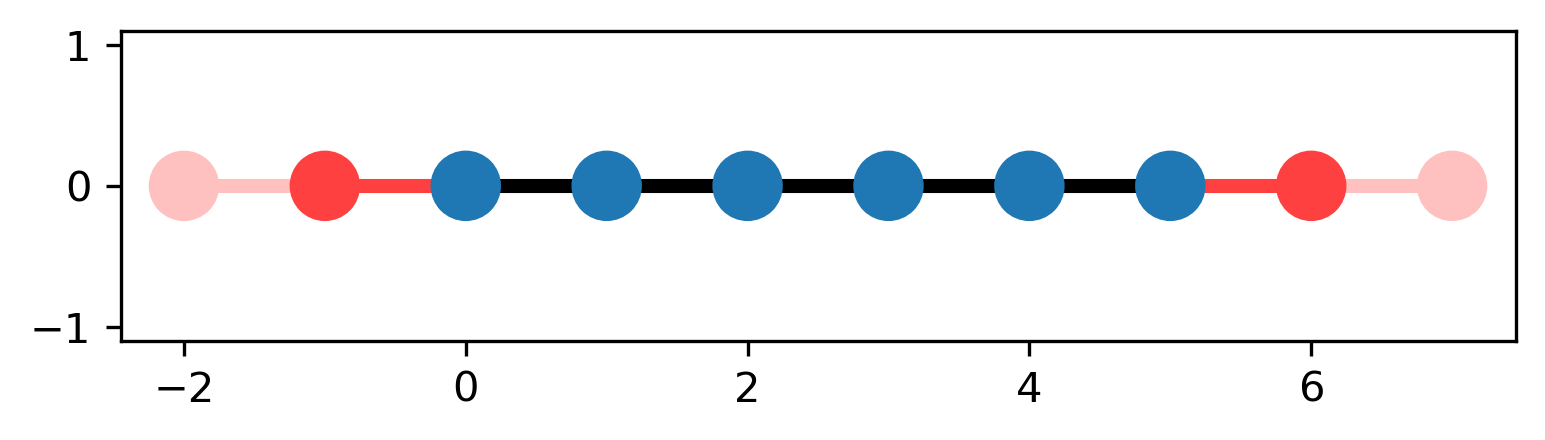

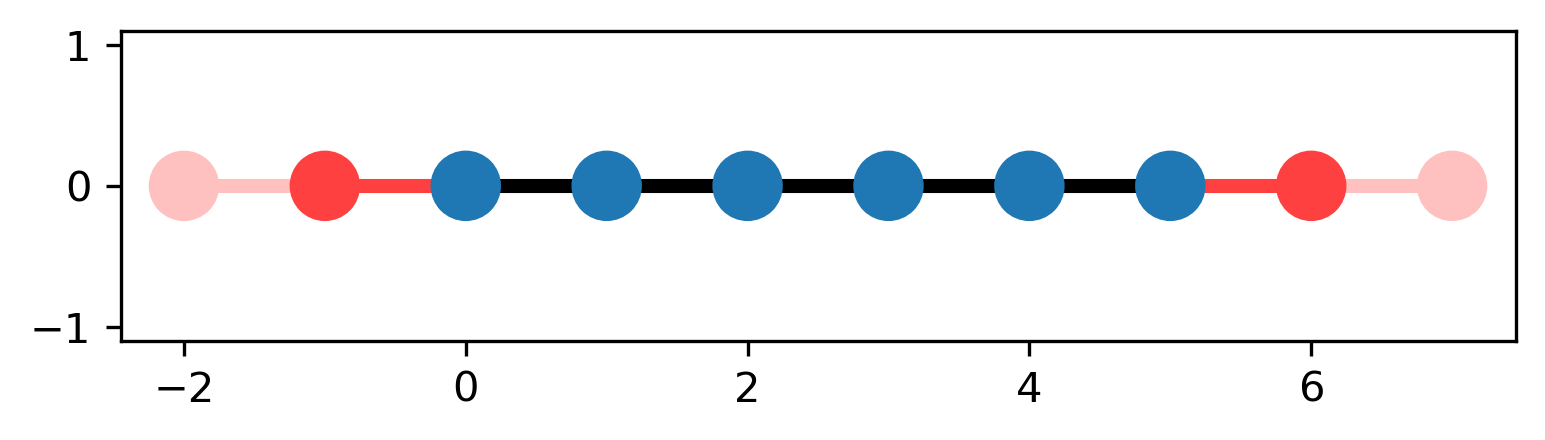

In [8]:
syst = make_system_mixed(L_A=3700., W=1400., a=605.83, m=0.023, alpha=350., mu=0., U_0=0., delta=0.182, B=0.85, phi=0., g=14.7, salt='chizhang', eta=None)
kwant.plot(syst, dpi=300)
#plt.savefig('./MSci Prez/syst', dpi=300)

In [5]:
def explicit_diagonalisation(syst, en):
    ham = syst.leads[0].cell_hamiltonian()
    hop = syst.leads[0].inter_cell_hopping()
    #print(ham)
    #print(hop)
    A = np.block([[ham-en*np.identity(ham.shape[0]), hop.T.conj()], [np.identity(ham.shape[0]), np.zeros(ham.shape)]])
    B = np.block([[-hop, np.zeros(ham.shape)], [np.zeros(ham.shape), np.identity(ham.shape[0])]])
    print(A.shape)
    eigvals, eigvecs = scipy.linalg.eig(A, b=B)
    lambdas = 1./eigvals
    print('lambdas')
    print(lambdas)
    print('size of lambdas')
    print(np.abs(lambdas))
    print('phase of lambdas')
    print(np.angle(lambdas))
    print('eigenvectors')
    print(eigvecs)
    print('small validation')
    print(eigvecs[0:8]/eigvecs[8:16])
    return lambdas, eigvecs

def validation(lmbda, phi, en):
    ham = syst.leads[0].cell_hamiltonian()
    hop = syst.leads[0].inter_cell_hopping()
    return hop@phi + lmbda*(ham-en*np.identity(ham.shape[0]))@phi + lmbda**2.*hop.T.conj()@phi

In [10]:
lmb = lambdas[1]
phi = eigvecs[:,1][0:8]
reduced_eigvecs = eigvecs[:,np.where(np.abs(lambdas)<=1.)[0]][0:8]
print(np.sum(np.abs(reduced_eigvecs)**2., axis=0))
print(lmb)
print(phi)
print(validation(lmb, phi, e_array6[0][1]))

[0.50098612 0.50098612 0.50144326 0.50004559 0.58468353 0.58468353
 0.58468353 0.58468353]
(0.9979405449349862-0.013339790216433755j)
[ 0.07474762-0.34167815j -0.35394145-0.05234626j  0.        +0.j
  0.        +0.j          0.28122539-0.21896663j -0.20197165-0.28777356j
  0.        +0.j          0.        +0.j        ]
[ 7.85746579e-10-7.15544957e-10j -2.12003215e-09-3.05504955e-09j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j
  4.34283720e-11+1.40971679e-11j -6.36646291e-12-1.81898940e-12j
  0.00000000e+00+0.00000000e+00j  0.00000000e+00+0.00000000e+00j]


In [9]:
syst = make_system_mixed(B=0.05, W=100., mu=132.3363682761002+0.2, eta=0., L_A=100., a=6.0583, phi=0.)
lambdas, eigvecs = explicit_diagonalisation(syst, e_array6[0][1])

Parameters: L, t, E_plus, E_minus, eta, nu, B
[17, 4513.29322846401, 198.78167562547094, -66.26055854182366, 0.0, 28.885991119621014, 0.05]
(16, 16)
lambdas
[1.00188468-1.33925128e-02j 0.99794054-1.33397902e-02j
 1.00188468+1.33925128e-02j 0.99794054+1.33397902e-02j
 1.00289069-2.63915221e-14j 0.99711764+4.22601664e-13j
 1.00009119-1.50899919e-13j 0.99990882-2.52378532e-13j
 0.84279127-5.46173646e-03j 0.84279214-5.32620221e-03j
 0.84279127+5.46173646e-03j 0.84279214+5.32620221e-03j
 1.18648358-7.68904574e-03j 1.1864848 -7.49824030e-03j
 1.1864848 +7.49824030e-03j 1.18648358+7.68904574e-03j]
size of lambdas
[1.00197419 0.9980297  1.00197419 0.9980297  1.00289069 0.99711764
 1.00009119 0.99990882 0.84280897 0.84280897 0.84280897 0.84280897
 1.1865085  1.18650849 1.18650849 1.1865085 ]
phase of lambdas
[-1.33665235e-02 -1.33665235e-02  1.33665235e-02  1.33665235e-02
 -2.63154522e-14  4.23823275e-13 -1.50886161e-13 -2.52401546e-13
 -6.48044206e-03 -6.31962624e-03  6.48044206e-03  6.3196262

/var/folders/tq/z3lkw8s95r1g4v3_7b8tv3_w0000gn/T/ipykernel_947/509635794.py:20: RuntimeWarning: invalid value encountered in true_divide
  print(eigvecs[0:8]/eigvecs[8:16])


In [11]:
syst = make_system_mixed(B=0.05, W=100., mu=132.3363682761002+0.2, eta=0., L_A=100., a=6.0583, phi=0.)
lambdas, eigvecs = explicit_diagonalisation(syst, 0.)

Parameters: L, t, E_plus, E_minus, eta, nu, B
[17, 4513.29322846401, 198.78167562547094, -66.26055854182366, 0.0, 28.885991119621014, 0.05]
(16, 16)
lambdas
[1.00268838+0.01367308j 0.99713341+0.01359733j 1.00268838-0.01367308j
 0.99713341-0.01359733j 1.00278155+0.00032742j 1.00278155-0.00032742j
 0.99722606-0.00032561j 0.99722606+0.00032561j 0.84279105-0.00549285j
 0.84279232-0.00529509j 0.84279105+0.00549285j 0.84279232+0.00529509j
 1.18648332-0.00773285j 1.1864851 -0.00745444j 1.18648332+0.00773285j
 1.1864851 +0.00745444j]
size of lambdas
[1.0027816  0.99722611 1.0027816  0.99722611 1.0027816  1.0027816
 0.99722611 0.99722611 0.84280895 0.84280895 0.84280895 0.84280895
 1.18650852 1.18650852 1.18650852 1.18650852]
phase of lambdas
[ 0.01363558  0.01363558 -0.01363558 -0.01363558  0.00032651 -0.00032651
 -0.00032651  0.00032651 -0.00651736 -0.00628271  0.00651736  0.00628271
 -0.00651736 -0.00628271  0.00651736  0.00628271]
eigenvectors
[[ 1.75170131e-01-0.31121205j  2.62996217e-04-0

/var/folders/tq/z3lkw8s95r1g4v3_7b8tv3_w0000gn/T/ipykernel_947/509635794.py:20: RuntimeWarning: invalid value encountered in true_divide
  print(eigvecs[0:8]/eigvecs[8:16])


In [12]:
syst = make_system_mixed(B=0.05, W=100., mu=132.3363682761002+0.2, eta=0., L_A=100., a=6.0583, phi=0.)
lambdas, eigvecs = explicit_diagonalisation(syst, 0.2)

Parameters: L, t, E_plus, E_minus, eta, nu, B
[17, 4513.29322846401, 198.78167562547094, -66.26055854182366, 0.0, 28.885991119621014, 0.05]
(16, 16)
lambdas
[0.99989705-1.43489692e-02j 0.99993377-1.15088203e-02j
 0.99989705+1.43489692e-02j 0.99993377+1.15088204e-02j
 0.99999655-2.62609847e-03j 0.99798862-1.73905350e-11j
 0.99999655+2.62609847e-03j 1.00201543+1.12572183e-15j
 0.84283678-5.39425757e-03j 0.84274668-5.39368144e-03j
 0.84283678+5.39425757e-03j 0.84274668+5.39368144e-03j
 1.18642074-7.59323660e-03j 1.18654758-7.59404909e-03j
 1.18642074+7.59323660e-03j 1.18654758+7.59404909e-03j]
size of lambdas
[1.         1.         1.         1.         1.         0.99798862
 1.         1.00201543 0.84285404 0.84276394 0.84285404 0.84276394
 1.18644504 1.18657188 1.18644504 1.18657188]
phase of lambdas
[-1.43494616e-02 -1.15090744e-02  1.43494616e-02  1.15090744e-02
 -2.62610149e-03 -1.74255845e-11  2.62610149e-03  1.12345757e-15
 -6.40003385e-03 -6.40003445e-03  6.40003385e-03  6.4000344

/var/folders/tq/z3lkw8s95r1g4v3_7b8tv3_w0000gn/T/ipykernel_947/509635794.py:20: RuntimeWarning: invalid value encountered in true_divide
  print(eigvecs[0:8]/eigvecs[8:16])


In [20]:
syst = make_system_mixed(L_A=100., W=100., mu=132.3363682761002+0.2, B=0.05, phi=0., eta=0.)
print(syst.hamiltonian_submatrix().shape)
#print(psi_array6[0][:,0])
#print((syst.hamiltonian_submatrix()@psi_array6[0][:,0])/psi_array6[0][:,0])
mat, norbs = syst.hamiltonian_submatrix(return_norb=True)[:2]
tot_norbs = sum(norbs)
print(tot_norbs)

'''for leadnum, interface in enumerate(syst.lead_interfaces):
    lead = syst.leads[leadnum]
    _, stab = lead.modes(e_array6[0][0])
    evan_vecs = slice(2 * stab.nmodes, None)
    u_out = stab.vecs[:, evan_vecs]
    u_out_over_lmbda = stab.vecslmbdainv[:, evan_vecs]
    #print(lead.inter_cell_hopping())
    #print(evan_vecs)
    #print(u_out)
    #print(u_out/u_out_over_lmbda)'''
    
print(e_array6[0][1])
evan_basis0 = syst.leads[0].modes(e_array6[0][1])[1].vecs
evan_basis0overlambda = syst.leads[1].modes(e_array6[0][1])[1].vecslmbdainv
print('sqrt_hop')
hop = syst.leads[0].inter_cell_hopping()
hop_dagger = hop.T.conj()
print(hop)
print(syst.leads[1].modes(e_array6[0][1])[1].sqrt_hop)
print(np.sqrt(scipy.linalg.svd(hop)[1]))
print(scipy.linalg.svd(hop)[2])
print(scipy.linalg.svd(hop)[0])
print(syst.leads[1].modes(e_array6[0][1])[1].sqrt_hop/np.diag(np.sqrt(scipy.linalg.svd(hop)[1])))
print(np.sqrt(np.sqrt(8.)))
print('evan_basis0')
print(evan_basis0)
print('evan_basis0overlambda')
print(evan_basis0overlambda)
print('nmodes')
print(syst.leads[0].modes(e_array6[0][1])[1].nmodes)
eigenvalues = evan_basis0/(hop_dagger@evan_basis0overlambda)
print('eigenvalues')
print(eigenvalues)
    
#trial_wavefunc = kwant.solvers.default.wave_function(syst, 0.182)
#print(trial_wavefunc(1))

#effective_H = make_linsys(syst, e_array6[0][0])
#print(effective_H)
temp_vec = extract_boundstates(syst, e_array6[0][0])
#e_trial, psi_trial = find_boundstates(syst, -1.1*0.182, 1.1*0.182, rtol=1e-2*0.182)
#print(temp_vec[0:136])
#print(psi_array6[0][:,0])
#print(temp_vec[:tot_norbs, :].flatten())
#print(-1j*np.log(temp_vec[:tot_norbs, :].flatten()/psi_array6[0][:,0]))

Parameters: L, t, E_plus, E_minus, eta, nu, B
[17, 4513.29322846401, 198.78167562547094, -66.26055854182366, 0.0, 28.885991119621014, 0.05]
(136, 136)
136
0.13253905731633014
sqrt_hop
[[-4513.29322846-0.j   -28.88599112-0.j     0.        -0.j
      0.        -0.j     0.        -0.j     0.        -0.j
      0.        -0.j     0.        -0.j]
 [   28.88599112-0.j -4513.29322846-0.j     0.        -0.j
      0.        -0.j     0.        -0.j     0.        -0.j
      0.        -0.j     0.        -0.j]
 [    0.        -0.j     0.        -0.j -4513.29322846-0.j
    -28.88599112-0.j     0.        -0.j     0.        -0.j
      0.        -0.j     0.        -0.j]
 [    0.        -0.j     0.        -0.j    28.88599112-0.j
  -4513.29322846-0.j     0.        -0.j     0.        -0.j
      0.        -0.j     0.        -0.j]
 [    0.        -0.j     0.        -0.j     0.        -0.j
      0.        -0.j  4513.29322846-0.j    28.88599112-0.j
      0.        -0.j     0.        -0.j]
 [    0.        -0.j 

/var/folders/tq/z3lkw8s95r1g4v3_7b8tv3_w0000gn/T/ipykernel_947/3941571239.py:31: RuntimeWarning: invalid value encountered in true_divide
  print(syst.leads[1].modes(e_array6[0][1])[1].sqrt_hop/np.diag(np.sqrt(scipy.linalg.svd(hop)[1])))


In [14]:
syst = make_system_mixed(L_A=100., W=100., mu=132.3363682761002+0.2, B=0.05, phi=0., eta=0.)

en=0.2
print(en)
evan_basis0 = syst.leads[0].modes(en)[1].vecs
evan_basis0overlambda = syst.leads[1].modes(en)[1].vecslmbdainv
eigenvalues = np.divide(evan_basis0, evan_basis0overlambda)
print('evan_basis0')
print(evan_basis0)
print('evan_basis0overlambda')
print(evan_basis0overlambda)
print('eigenvalues')
print(eigenvalues)
print('size of lambdas')
print(np.abs(eigenvalues))
#print('test 1/sqrt(number of orbitals)')
#print(1./np.sqrt(8.))
#print('1 over size of lambdas')
#print(1./np.abs(eigenvalues))
print('phase of the lambdas, or k')
print(np.angle(eigenvalues))
print('number of prop modes')
print(syst.leads[1].modes(en)[1].nmodes)
print('prop wavefunctions')
print(syst.leads[0].modes(en)[0].wave_functions)
print('momenta')
print(syst.leads[0].modes(en)[0].momenta)
print('vel')
print(syst.leads[0].modes(en)[0].velocities)

Parameters: L, t, E_plus, E_minus, eta, nu, B
[17, 4513.29322846401, 198.78167562547094, -66.26055854182366, 0.0, 28.885991119621014, 0.05]
0.2
evan_basis0
[[ 3.15104441e+00-2.98180988e+00j  2.84833968e+00+8.51877691e-01j
   2.31678712e+00-2.57110359e+00j  3.15104441e+00+2.98180988e+00j
   2.84833968e+00-8.51877691e-01j  2.31678712e+00+2.57110359e+00j
   1.37084950e-01+0.00000000e+00j  3.88578059e-15+0.00000000e+00j
   1.38777878e-15+0.00000000e+00j  2.58126853e-15+0.00000000e+00j
  -3.88578059e-16+0.00000000e+00j]
 [-3.18600623e+00-2.93887138e+00j -2.80810319e+00+8.76141902e-01j
   2.29354216e+00+2.58526684e+00j -3.18600623e+00+2.93887138e+00j
  -2.80810319e+00-8.76141902e-01j  2.29354216e+00-2.58526684e+00j
   1.66895788e-01+0.00000000e+00j  6.91113833e-15+0.00000000e+00j
  -7.28583860e-16+0.00000000e+00j -1.33226763e-15+0.00000000e+00j
   2.44249065e-15+0.00000000e+00j]
 [-1.04146839e-14-9.07059274e-15j -8.96003811e-15+2.90959272e-15j
   7.08406774e-15+8.46914657e-15j -1.04146839e-1

In [ ]:
-1.43494616e-02 -1.15090744e-02  1.43494616e-02  1.15090744e-02
 -2.62610149e-03 

Parameters: L, t, E_plus, E_minus, eta, nu, B
[2, 45.13293228464011, 198.78167562547094, -66.26055854182366, 0.0, 2.8885991119621015, 0.05]


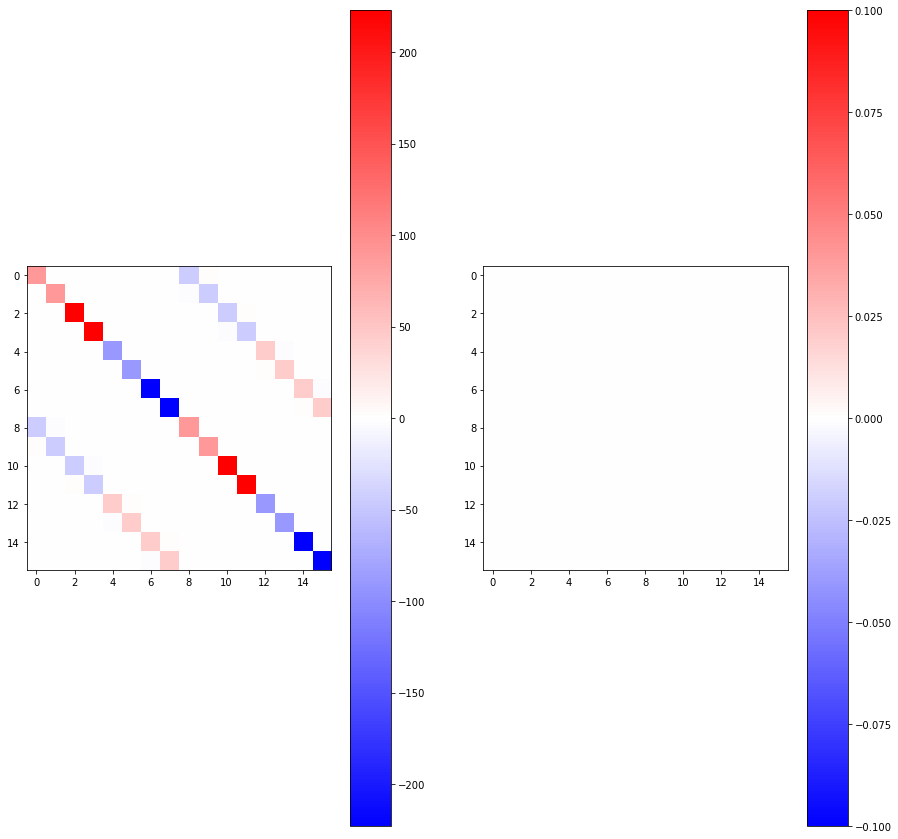

In [154]:
syst = make_system_mixed(B=0.05, W=100., mu=132.3363682761002+0.2, eta=0., L_A=100., a=60.583, phi=np.pi/2.)
ham_bdg = syst.hamiltonian_submatrix()

norm1 = colors.TwoSlopeNorm(vcenter=0)
norm2 = colors.TwoSlopeNorm(vcenter=0)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,15))
im1 = ax1.imshow(np.real(ham_bdg), cmap='bwr', interpolation='none', norm=norm1)
fig.colorbar(im1, ax=ax1)
im2 = ax2.imshow(np.imag(ham_bdg), cmap='bwr', interpolation='none', norm=norm2)
fig.colorbar(im2, ax=ax2)

In [21]:
#13251.741972368807 subband mixing on, B=0
#13251.92683565613 subband mixing off, B=0
#132.3363682761002 subband mixing off, B=0, W=100
import matplotlib
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 22}

matplotlib.rc('font', **font)

In [29]:
0.574/1.35*2

0.8503703703703702

Parameters: L, t, E_plus, E_minus, eta, nu, B
[608, 4476.715219575398, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 28.768699654775602, 0.8508921254871452]
Spectral gap:
0.08092005667557485
0.4457354482961006
Fermi momentum
17319907.338674992
Fermi wavelength:
3.627724550898355e-07
(array([49692, 49833, 50167, 50308]),)
[[0.12225245 0.08092006 0.08092006 0.12225245]]
[0.01935221 0.01049292 0.01049292 0.01935221]


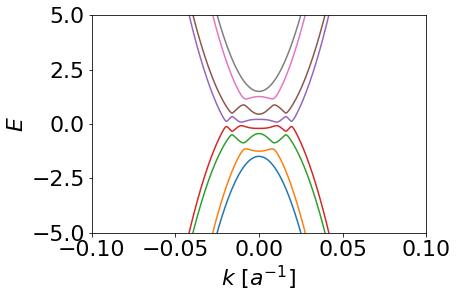

In [64]:
#syst = make_system_mixed(B=0.182, W=100., mu=132.3363682761002+0.2, eta=0., L_A=100.)
syst = make_system_mixed(L_A=3700., W=1400., a=6.083, m=0.023, alpha=350., mu=0.887, U_0=0., delta=0.182, B=0.8508921254871452, phi=0., g=14.7, salt='chizhang', eta=None)
bands=kwant.physics.Bands(syst.leads[1])
momenta=np.linspace(-np.pi,np.pi,100001)
energies=[bands(k) for k in momenta]
x=np.array(energies)
en=(x)
plt.plot(momenta, en)
#plt.plot(momenta, dispersion(momenta, 1), ls=':')
#plt.plot(momenta, dispersion(momenta, 2), ls=':')
#plt.scatter(np.linspace(-0.1, 0.1, 50), dispersion(np.linspace(-0.1, 0.1, 50), 1), marker='x')
#plt.scatter(np.linspace(-0.1, 0.1, 50), dispersion(np.linspace(-0.1, 0.1, 50), 2), marker='x')
plt.xlabel(r'$k\ [a^{-1}]$')
plt.ylabel(r'$E$')
plt.xlim(-0.1, 0.1)
#plt.ylim(-2.5e4, 2.5e4)
plt.ylim(-5, 5)

print('Spectral gap:')
print(np.min(en[:,4]))
print(np.min(en[:,5]))
print('Fermi momentum')
k_F = np.abs(np.linspace(-np.pi,np.pi,100001)[np.argmin(en[:,4])])/6.0583e-10
print(k_F)
print('Fermi wavelength:')
print(2.*np.pi/k_F)
# Fermi wavelength comparable to junction length
local_minima = signal.argrelextrema(en[:,4], np.less)
print(local_minima)
print(en[local_minima, 4])
print(np.abs(np.linspace(-np.pi,np.pi,100001)[local_minima]))
#plt.savefig('./MSci Prez/subband-not-mixed band', dpi=300, bbox_inches='tight')



In [ ]:
j=0
for i in np.linspace(0, 0.8508921254871452):
    syst = make_system_mixed(L_A=3700., W=1400., a=6.083, m=0.023, alpha=350., mu=0.887, U_0=0., delta=0.182, B=i, phi=0., g=14.7, salt='chizhang', eta=None)
    bands=kwant.physics.Bands(syst.leads[1])
    momenta=np.linspace(-np.pi,np.pi,10001)
    energies=[bands(k) for k in momenta]
    x=np.array(energies)
    en=(x/0.182)
    plt.figure()
    plt.plot(momenta, en)
    plt.xlabel(r'$k\ [a^{-1}]$')
    plt.ylabel(r'$E/\Delta$')
    plt.xlim(-0.1, 0.1)
    plt.ylim(-6, 6)
    plt.axhline(np.min(en[:,4]), ls='--', c='k', alpha=0.7)
    plt.axhline(-np.min(en[:,4]), ls='--', c='k', alpha=0.7)
    plt.savefig('./MSci Prez/Gif1 Alter/i=%s' % (str(j)), dpi=300, bbox_inches='tight')
    j+=1

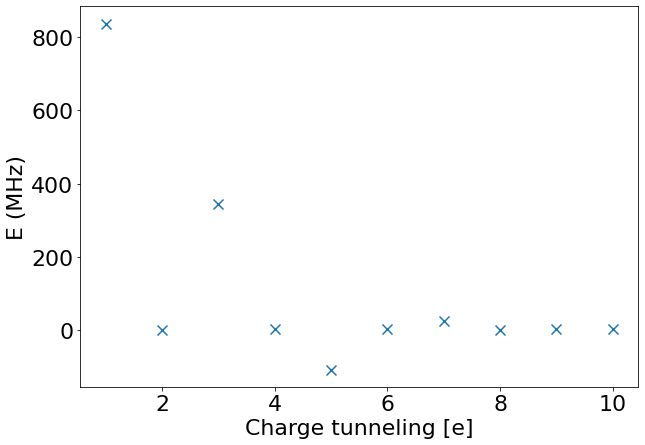

In [90]:
plt.figure(figsize=(10, 7))
fourier_array = np.array([8.37e8, 1.97e6, 3.45e8, 2.24e6, -1.07e8, 2.30e6, 2.48e7, 1.97e6, 4.60e6, 2.38e6])
plt.scatter(np.arange(1, 11), fourier_array/1e6, s=100, marker='x')
plt.xlabel('Charge tunneling [e]')
plt.ylabel('E (MHz)')
plt.savefig('./MSci Prez/Fourier coeffs', dpi=300, bbox_inches='tight')

In [5]:
print((np.sqrt(0.182**2.+0.422**2.)))

0.4595737155234185


In [46]:
def band_gap(L_A=3700., W=1400., a=6.0583*10, m=0.023, alpha=350., mu=0.887, U_0=0., delta=0.182, B=0., g=14.7, salt='chizhang', eta=None, phi=0.):
    syst = make_system_mixed(L_A=L_A, W=W, a=a, m=m, alpha=alpha, mu=mu, U_0=U_0, delta=delta, B=B, g=g, phi=phi, salt='chizhang', eta=eta)
    bands=kwant.physics.Bands(syst.leads[1])
    momenta=np.linspace(-np.pi,np.pi,100001)
    energies=[bands(k) for k in momenta]
    x=np.array(energies)
    en=(x)
    
    return np.min(en[:,4]), np.min(en[:,5])

In [272]:
B_gap_array = []
for i in np.linspace(0, 0.8508921254871452):
    B_gap_en = band_gap(B=i,W=100., mu=132.3363682761002+0.2, eta=0., L_A=100.)
    B_gap_array.append(B_gap_en)
print(B_gap_array)

Parameters: L, t, E_plus, E_minus, eta, nu, B
[2, 45.13293228464011, 198.78167562547094, -66.26055854182366, 0.0, 2.8885991119621015, 0.0]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[2, 45.13293228464011, 198.78167562547094, -66.26055854182366, 0.0, 2.8885991119621015, 0.011714285714285714]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[2, 45.13293228464011, 198.78167562547094, -66.26055854182366, 0.0, 2.8885991119621015, 0.023428571428571427]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[2, 45.13293228464011, 198.78167562547094, -66.26055854182366, 0.0, 2.8885991119621015, 0.03514285714285714]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[2, 45.13293228464011, 198.78167562547094, -66.26055854182366, 0.0, 2.8885991119621015, 0.046857142857142854]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[2, 45.13293228464011, 198.78167562547094, -66.26055854182366, 0.0, 2.8885991119621015, 0.058571428571428566]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[2, 45.13293228464011, 198.781675625

In [8]:
#B_gap_en = band_gap(W=1e-2, mu=13252111707.99499+0.422, B=0.45)
#print(B_gap_en)

Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 19878167562.5471, -6626055854.182365, 49497.474683058324, 2.8885991119621015, 0.45]
0.15107746624259222


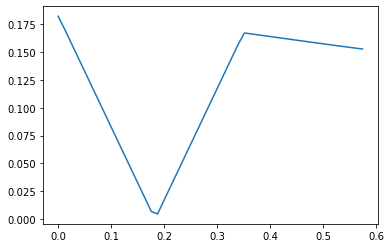

In [273]:
plt.plot(np.linspace(0, 0.574), B_gap_array)

In [33]:
import pickle
B_e_array = pickle.load(open('./subband/data/B scan', 'rb'))
#print(B_e_array)

In [47]:
B_gap_array0 = []
B_gap_array1 = []
for i in np.linspace(0, 0.8508921254871452):
    B_gap0, B_gap1 = band_gap(B=i)
    B_gap_array0.append(B_gap0)
    B_gap_array1.append(B_gap1)
print(B_gap_array0)
print(B_gap_array1)

Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 2.8885991119621015, 0.0]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 2.8885991119621015, 0.017365145418105004]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 2.8885991119621015, 0.03473029083621001]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 2.8885991119621015, 0.05209543625431501]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 2.8885991119621015, 0.06946058167242002]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 1.0141922225789335, -0.3380640741929778, 0.3535533905932738, 2.8885991119621015, 0.08

In [44]:
def B_plot(energy_array, delta=0.182, title=r'$L=3700, W=1400, \mu=0.887, \Delta=0.182, \phi=0$'):
    ex=[]
    ey=[]
    
    ex1=[]
    ey1=[]
    ex2=[]
    ey2=[]
    
    B = np.linspace(0, 2)
    B1 = np.linspace(0, 2)
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(B[i])
            ey.append(energy_array[i][j])
    '''for i in range(len(analytic_array[0])):
        for j in range(len(analytic_array[0][i])):
            ex1.append(phi1[i])
            ey1.append(analytic_array[0][i][j])
    for i in range(len(analytic_array[1])):
        for j in range(len(analytic_array[1][i])):
            ex2.append(phi1[i])
            ey2.append(analytic_array[1][i][j])'''
        
    ex = np.array(ex)
    ey = np.array(ey)/delta
    #plt.axhline(gap/delta, color='r')
    #plt.axhline(-gap/delta, color='r')
    plt.scatter(ex, ey, s=5)
    #plt.scatter(ex1, ey1, s=5, c='orange', marker='_')
    #plt.scatter(ex2, ey2, s=5, c='green', marker='_')
    #plt.xlim(B_range[0], B_range[1])
    plt.xlabel(r'$B$')
    plt.ylabel(r'$E/\Delta$')
    #plt.xticks(ticks=np.linspace(0, 4.*np.pi, 5), labels=[r'$0$', r'$\pi$', r'$2\pi$', r'$3\pi$', r'$4\pi$'])
    #plt.ylim(-1.1, 1.1)
    plt.title(title, fontsize=18)
    #plt.savefig('./subband/'+figure_title, dpi=300)

In [60]:
print(np.linspace(0, 2))

[0.         0.04081633 0.08163265 0.12244898 0.16326531 0.20408163
 0.24489796 0.28571429 0.32653061 0.36734694 0.40816327 0.44897959
 0.48979592 0.53061224 0.57142857 0.6122449  0.65306122 0.69387755
 0.73469388 0.7755102  0.81632653 0.85714286 0.89795918 0.93877551
 0.97959184 1.02040816 1.06122449 1.10204082 1.14285714 1.18367347
 1.2244898  1.26530612 1.30612245 1.34693878 1.3877551  1.42857143
 1.46938776 1.51020408 1.55102041 1.59183673 1.63265306 1.67346939
 1.71428571 1.75510204 1.79591837 1.83673469 1.87755102 1.91836735
 1.95918367 2.        ]


/var/folders/tq/z3lkw8s95r1g4v3_7b8tv3_w0000gn/T/ipykernel_20649/448529033.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()


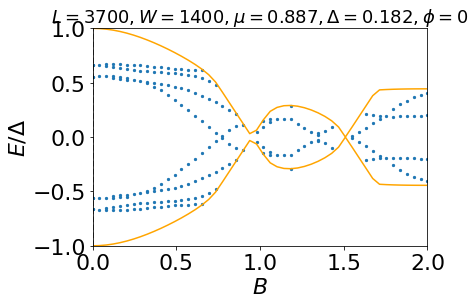

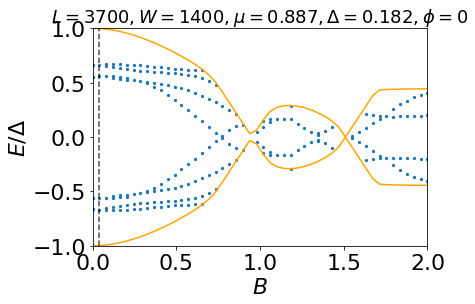

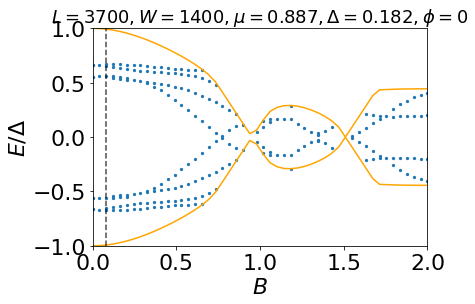

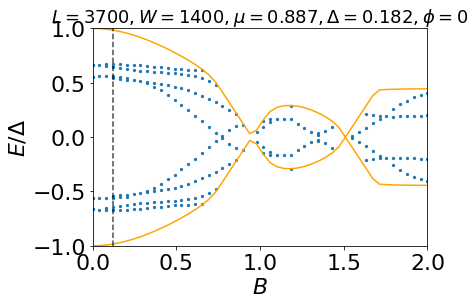

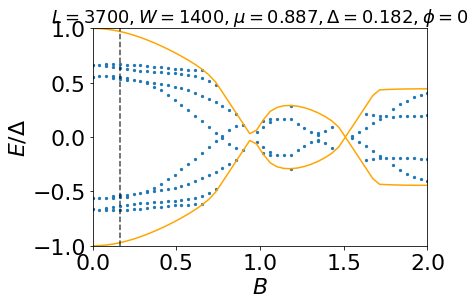

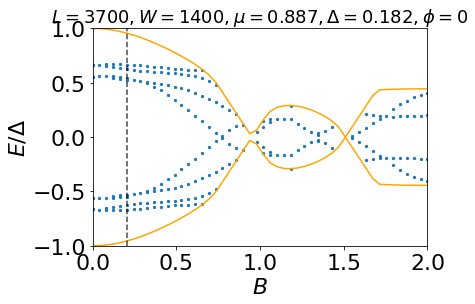

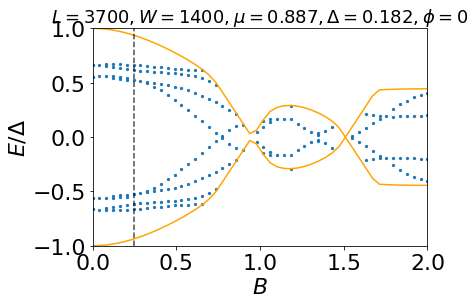

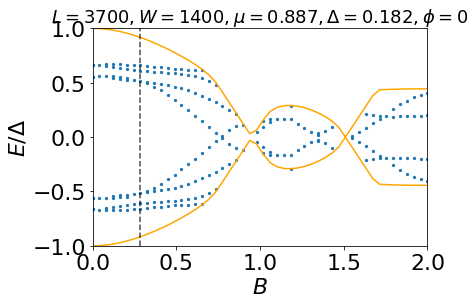

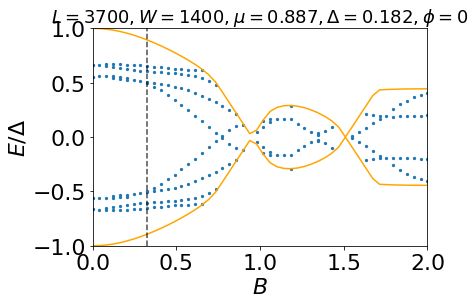

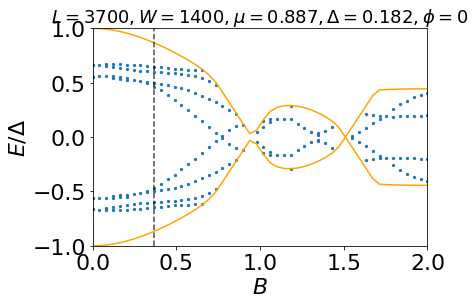

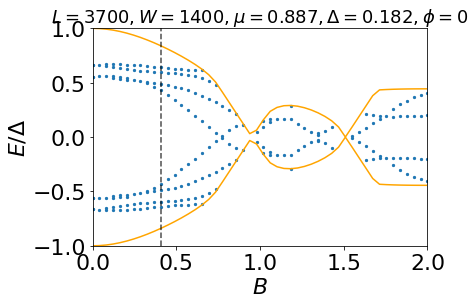

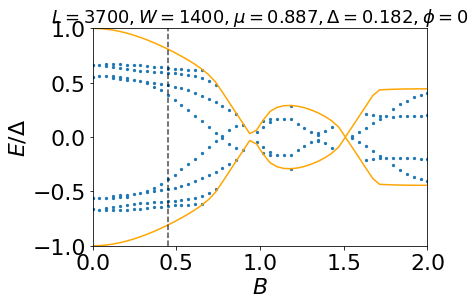

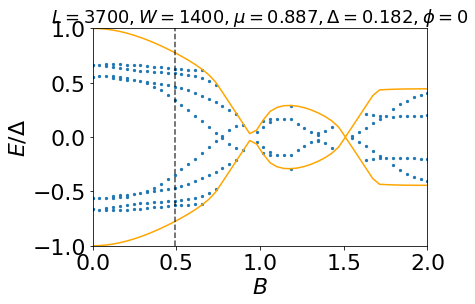

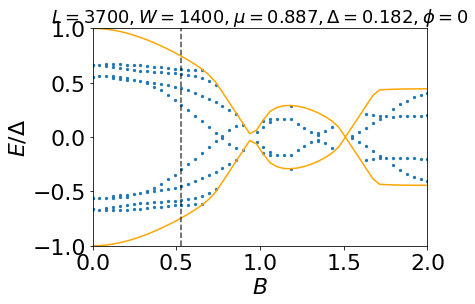

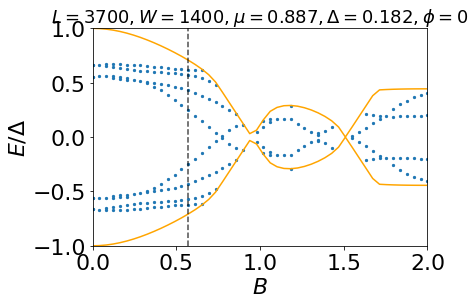

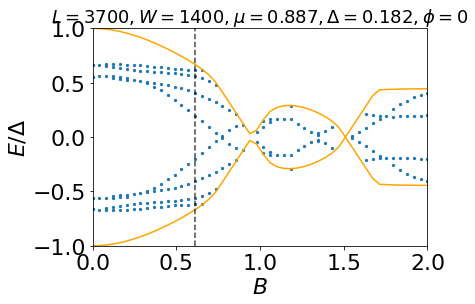

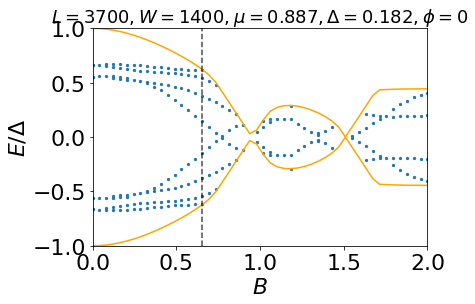

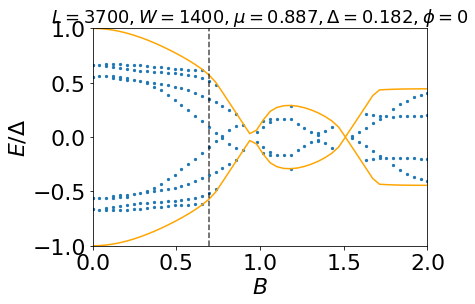

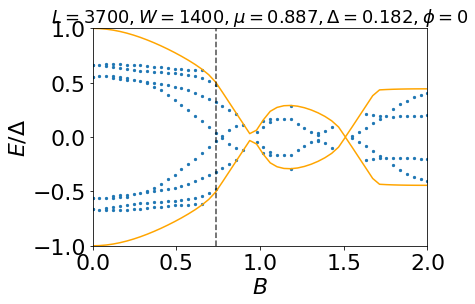

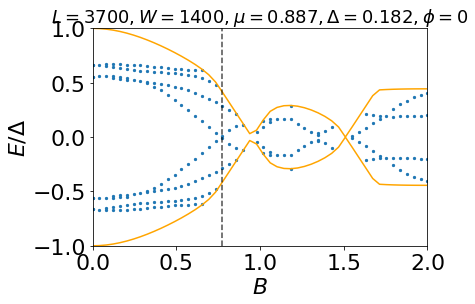

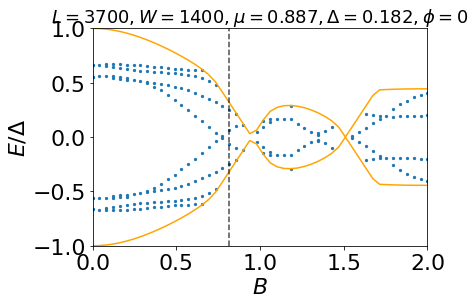

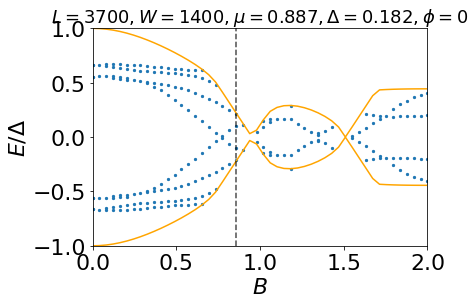

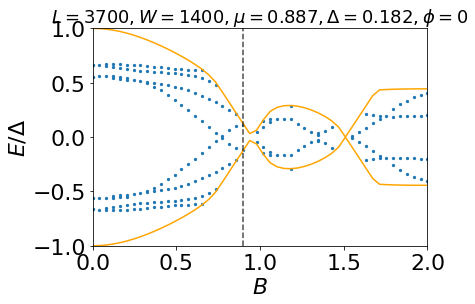

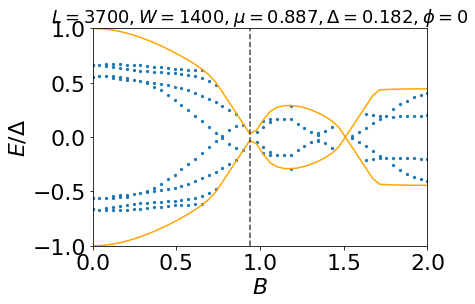

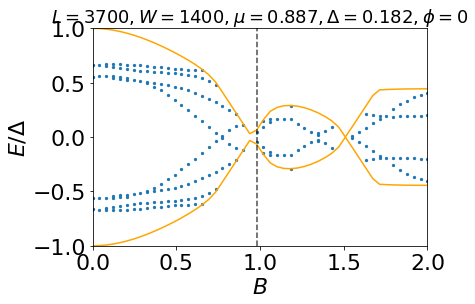

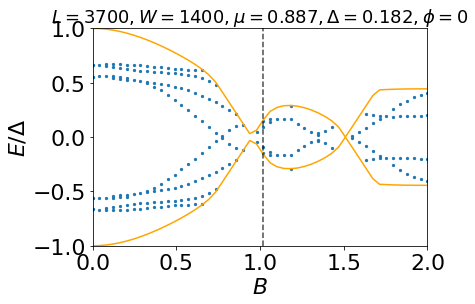

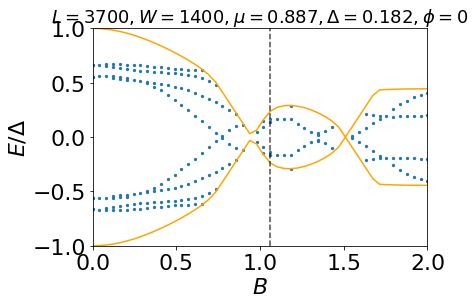

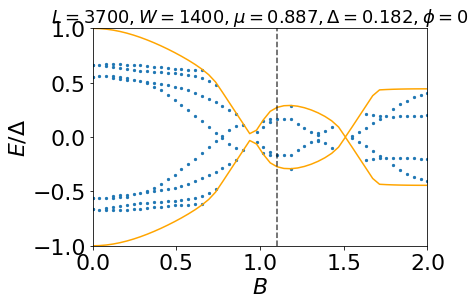

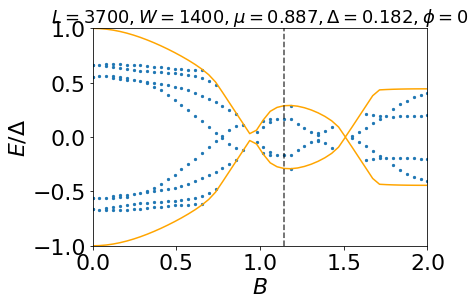

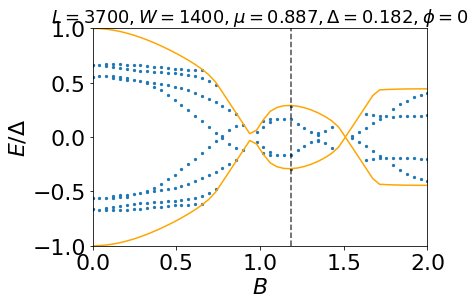

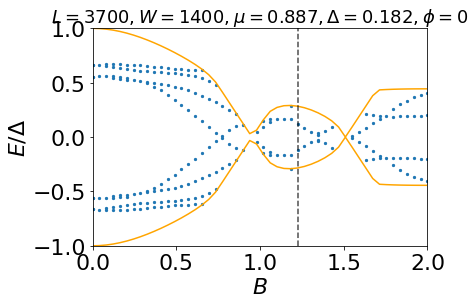

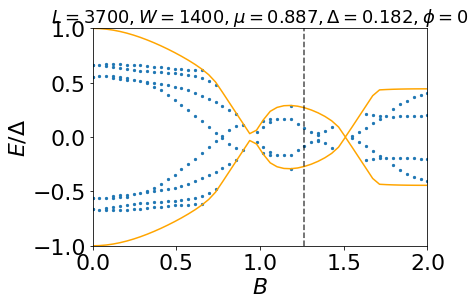

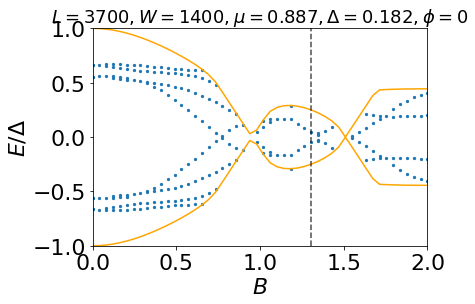

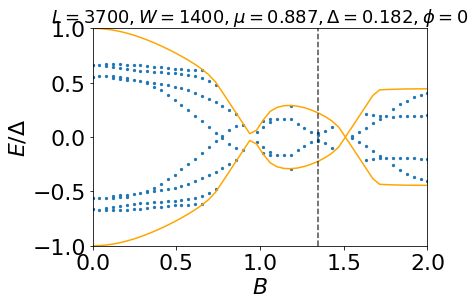

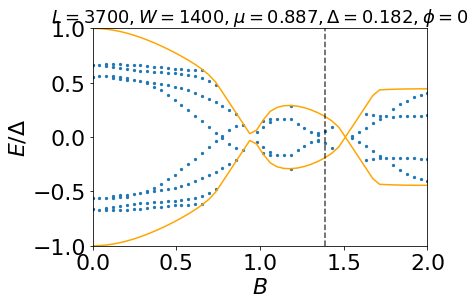

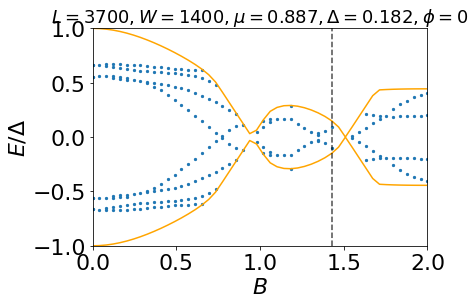

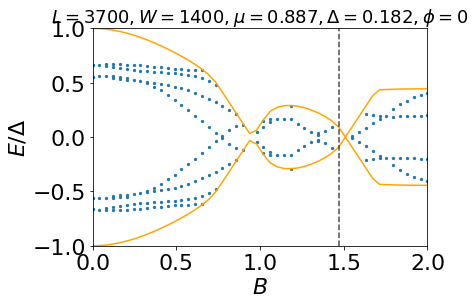

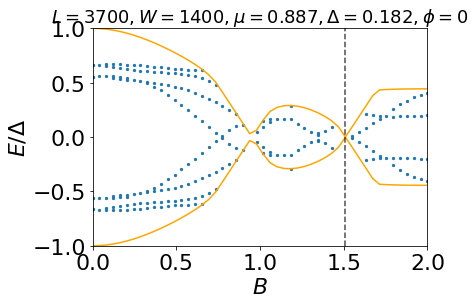

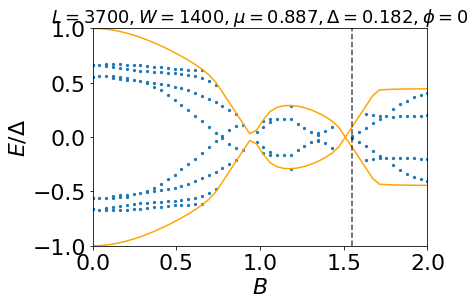

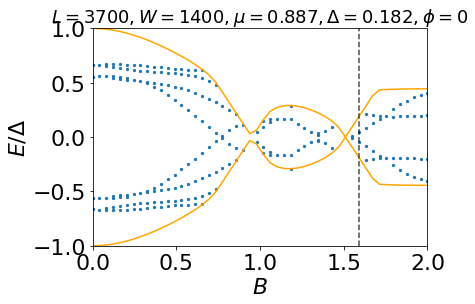

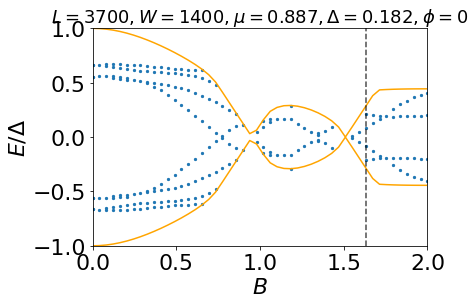

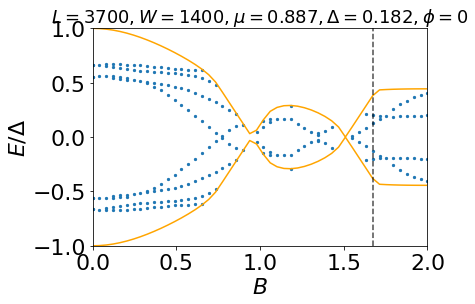

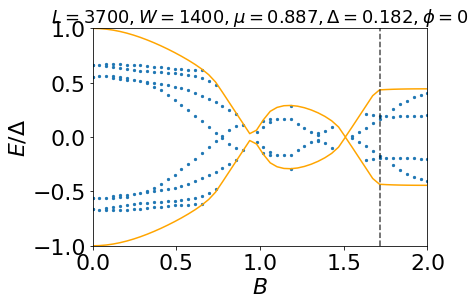

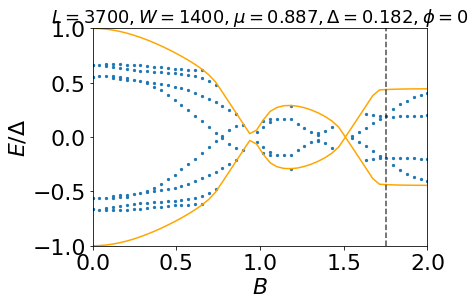

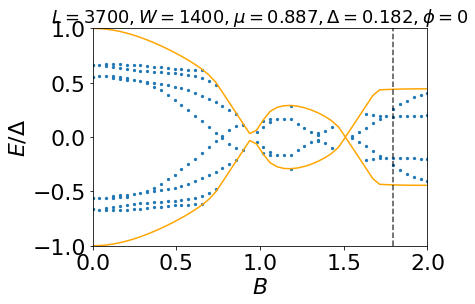

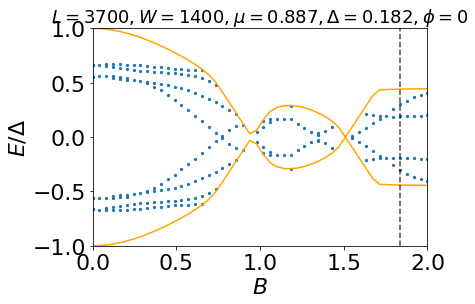

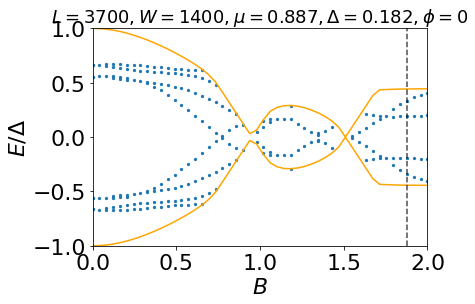

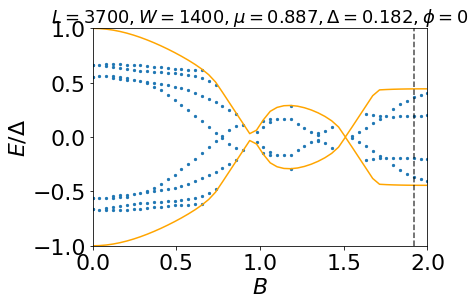

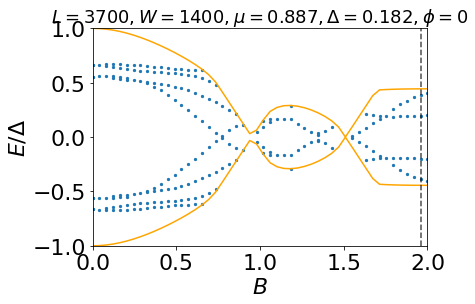

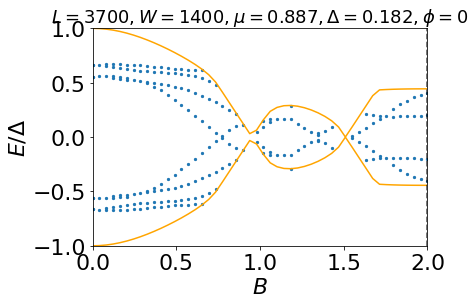

In [68]:
j=0
for i in np.linspace(0, 2):
    plt.figure()
    B_plot(B_e_array)
    plt.plot(np.linspace(0, 2), np.array(B_gap_array0)/0.182, c='orange')
    plt.plot(np.linspace(0, 2), -np.array(B_gap_array0)/0.182, c='orange')
    plt.axvline(i, ls='--', c='k', alpha=0.7)
    plt.xlim(0, 2)
    plt.ylim(-1., 1.)
    plt.savefig('./MSci Prez/Gif2/i=%s' % (str(j)), dpi=300, bbox_inches='tight')
    j+=1
    #plt.plot(np.linspace(0, 2), np.array(B_gap_array1)/0.182)

In [6]:
def phi_scan(phi_array=[0, 4.*np.pi], L_A=3700., W=1400., a=6.0583*10, m=0.023, alpha=350., mu=0.887, U_0=0., delta=0.182, B=0., g=14.7, salt='chizhang', eta=None):
    energy_arrays=[]
    wavefunc_arrays=[]
    for i in np.linspace(phi_array[0], phi_array[1], 41):
        print(i)
        syst = make_system_mixed(L_A=L_A, W=W, a=a, m=m, alpha=alpha, mu=mu, U_0=U_0, delta=delta, B=B, g=g, phi=i, salt='chizhang', eta=eta)
        energies, wavefunctions = find_boundstates(syst, -1.1*delta, 1.1*delta, rtol=1e-2*delta)
        energy_arrays.append(energies)
        wavefunc_arrays.append(wavefunctions)
        print(energies)
    return energy_arrays, wavefunc_arrays

In [ ]:
plt.plot(np.arange(10), np.arange(10))
plt.ylabel(r'$|\psi_{0, \uparrow}^{e}|^2$', fontsize=18)
plt.savefig('./subband transition/random fig', dpi=300)

In [7]:
def wavefunc_visualiser(psi, pt_index, size=61, orbital_no=8):
    wavefunc = psi[:, pt_index]
    orbitals = []
    labels = [r'$|\psi_{0, \uparrow}^{e}|^2$', r'$|\psi_{0, \downarrow}^{e}|^2$', r'$|\psi_{1, \uparrow}^{e}|^2$', r'$|\psi_{1, \downarrow}^{e}|^2$', r'$|\psi_{0, \uparrow}^{h}|^2$', r'$|\psi_{0, \downarrow}^{h}|^2$', r'$|\psi_{1, \uparrow}^{h}|^2$', r'$|\psi_{1, \downarrow}^{h}|^2$']
    for i in range(orbital_no):
        orbitals.append(wavefunc[i::orbital_no])
    
    fig, axes = plt.subplots(int(orbital_no/2), 2, figsize=(15,15))
    for i in range(len(axes.ravel())):
        axes.ravel()[i].plot(np.arange(0, size), np.abs(orbitals[i])**2.)
        axes.ravel()[i].set(xlabel='Site indices', ylabel=labels[i])
        axes.ravel()[i].xaxis.label.set_fontsize(16)
        axes.ravel()[i].yaxis.label.set_fontsize(18)
    
    #print orbital probs
    orbital_probs = []
    for i in range(orbital_no):
        orbital_prob = np.sum(np.abs(orbitals[i])**2.)
        orbital_probs.append(orbital_prob)
        print(orbital_prob)
    
    #print total prob
    orbital_probs = np.array(orbital_probs)
    print(np.sum(orbital_probs))
    
    return orbital_probs

In [8]:
def phi_plot(energy_array, figure_title, gap_energy1=None, delta=0.182, title=r'$L=3700, W=1400, mu=0.887, delta=0.182, B=0T$'):
    ex=[]
    ey=[]
    
    ex1=[]
    ey1=[]
    ex2=[]
    ey2=[]
    
    phi = np.linspace(0, 4.*np.pi, 41)
    phi1 = np.linspace(0, 4*np.pi, 101)
    for i in range(len(energy_array)):
        for j in range(len(energy_array[i])):
            ex.append(phi[i])
            ey.append(energy_array[i][j])
    '''for i in range(len(analytic_array[0])):
        for j in range(len(analytic_array[0][i])):
            ex1.append(phi1[i])
            ey1.append(analytic_array[0][i][j])
    for i in range(len(analytic_array[1])):
        for j in range(len(analytic_array[1][i])):
            ex2.append(phi1[i])
            ey2.append(analytic_array[1][i][j])'''
        
    ex = np.array(ex)
    ey = np.array(ey)/delta
    #plt.axhline(gap/delta, color='r')
    #plt.axhline(-gap/delta, color='r')
    plt.scatter(ex, ey, s=5)
    #plt.scatter(ex1, ey1, s=5, c='orange', marker='_')
    #plt.scatter(ex2, ey2, s=5, c='green', marker='_')
    #plt.xlim(B_range[0], B_range[1])
    plt.xlabel(r'$\phi$')
    plt.ylabel(r'$E/\Delta$')
    plt.xticks(ticks=np.linspace(0, 4.*np.pi, 5), labels=[r'$0$', r'$\pi$', r'$2\pi$', r'$3\pi$', r'$4\pi$'])
    plt.xlim(0, 4.*np.pi)
    plt.ylim(-1.05, 1.05)
    if gap_energy1 is not None:
        plt.axhline(gap_energy1/delta, color='r', ls='--', alpha=0.3)
        plt.axhline(-gap_energy1/delta, color='r', ls='--', alpha=0.3)
        #plt.axhline(0.15798419/delta, color='g', ls='--', alpha=0.3)
        #plt.axhline(-0.15798419/delta, color='g', ls='--', alpha=0.3)
    #for gap_energy2 in gap_energies2:
    #    plt.axhline(gap_energy2, color='g', ls='--')
    plt.title(title)
    plt.savefig('./subband transition/'+figure_title, dpi=300)

In [134]:
print(np.pi/10.*9.)

2.827433388230814


In [9]:
def contribution_phi_plot(contribution):
    labels = [r'$\psi_{0, \uparrow}^{e}$', r'$\psi_{0, \downarrow}^{e}$', r'$\psi_{1, \uparrow}^{e}$', r'$\psi_{1, \downarrow}^{e}$', r'$\psi_{0, \uparrow}^{h}$', r'$-\psi_{0, \downarrow}^{h}$', r'$\psi_{1, \uparrow}^{h}$', r'$-\psi_{1, \downarrow}^{h}$']
    for i in range(len(contribution[0])):
        plt.plot(np.linspace(0, 4.*np.pi, 41), contribution[:,i], label=labels[i])
    plt.xlabel(r'$\phi$')
    plt.ylabel('relative contribution')
    plt.xticks(ticks=np.linspace(0, 4.*np.pi, 5), labels=[r'$0$', r'$\pi$', r'$2\pi$', r'$3\pi$', r'$4\pi$'])
    plt.xlim(0, 4*np.pi)
    plt.legend(bbox_to_anchor=(1.1, 1.05), fontsize=16)

In [10]:
def total_prob(contribution):
    plt.plot(np.linspace(0, 4*np.pi, 41), np.sum(contribution, axis=1))

In [235]:
print(np.array([1+1j, 2-2j]).T.conj().dot(np.array([1+1j, 2-2j])))
print(np.sum(np.abs(np.array([1+1j, 2-2j]))**2.))

(10+0j)
10.000000000000002


In [114]:
def matrix_element(psi1, psi2, d_psi1, d_psi2, phi_incre, H):
    psi1prime = psi1*np.exp(-1j*np.angle(psi1[0]))
    #print(psi1prime[0:16])
    psi2prime = psi2*np.exp(-1j*np.angle(psi2[0]))
    #print(psi2prime[0:16])
    d_psi1prime = d_psi1*np.exp(-1j*np.angle(d_psi1[0]))
    d_psi2prime = d_psi2*np.exp(-1j*np.angle(d_psi2[0]))
    #print(d_psiprime[0:16])
    #print(d_psiprime[0:16]-psi2prime[0:16])
    diff_psi1 = (d_psi1prime - psi1prime)/phi_incre
    diff_psi2 = (d_psi2prime - psi2prime)/phi_incre
    return (psi1prime.T.conj()@H@diff_psi2 + diff_psi1.T.conj()@H@psi2prime)/(np.sqrt(psi1prime.T.conj()@psi1prime)*np.sqrt(psi2prime.T.conj()@psi2prime))

In [174]:
print(np.sqrt(psi_array6[0][:,0].T.conj()@psi_array6[0][:,0]))
print(np.sqrt(psi_array6[0][:,1].T.conj()@psi_array6[0][:,1]))
print()

(0.024327983594455416+0j)
(0.02432798359450175+0j)


In [115]:
syst = make_system_mixed(B=0.05, W=100., mu=132.3363682761002+0.2, eta=0., L_A=100., a=6.0583)
np.abs(matrix_element(psi_array6[0][:,0], psi_array6[0][:,1], psi_array6dif[0][:,0], psi_array6dif[0][:,1], 1e-3, syst.hamiltonian_submatrix()))

Parameters: L, t, E_plus, E_minus, eta, nu, B
[17, 4513.29322846401, 198.78167562547094, -66.26055854182366, 0.0, 28.885991119621014, 0.05]


0.09369811768607739

In [237]:
print(psi_array5prime[0][:,1][0:4])
+ diff_psi1.T.conj()@H@psi2prime

[1.18758914e-02 4.44111854e-02 1.01695577e-18 2.49012718e-19]


In [112]:
def transition_element_squared_phi(psi1_array, psi2_array, d_psi_array, pt_ind_array1, pt_ind_array2, pt_ind_arrayd1, pt_ind_arrayd2, incre, L_A=3700., W=1400., a=6.0583*10, m=0.023, alpha=350., mu=0.887, U_0=0., delta=0.182, B=0., g=14.7, salt='chizhang', eta=None):    
    phi_array = np.linspace(0, 4*np.pi, 41)
    matrix_element_array = []
    for i in range(len(phi_array)):
        psi1_array_prep = psi1_array[i][:,pt_ind_array1[i]]
        psi2_array_prep = psi2_array[i][:,pt_ind_array2[i]]
        d_psi1_array_prep = d_psi_array[i][:,pt_ind_arrayd1[i]]
        d_psi2_array_prep = d_psi_array[i][:,pt_ind_arrayd2[i]]
        syst = make_system_mixed(L_A=L_A, W=W, a=a, m=m, alpha=alpha, mu=mu, U_0=U_0, delta=delta, B=B, g=g, phi=i, salt='chizhang', eta=eta)
        matrix_element_array.append(matrix_element(psi1_array_prep, psi2_array_prep, d_psi1_array_prep, d_psi2_array_prep, incre, syst.hamiltonian_submatrix()))
    matrix_element_array = np.array(matrix_element_array)
    return np.abs(matrix_element_array)**2.

In [96]:
def numerical_M_squared_short(E_A, delta=0.182, tau=1-1e-6):
    M = delta*np.sqrt(1.-tau)/2.*(delta/E_A+E_A/delta)
    return M**2.

In [ ]:
'''        if i==0:
            psi_array_prep.append(psi_array[i][:,pt_ind_array[i]])
        else:
            psi_temp = psi_array[i][:,pt_ind_array[i]]
            global_phase = np.average(np.log(psi_temp/psi_array_prep[0])/1j)
            psi_array_prep.append(psi_temp*np.exp(-1j*global_phase))
    psi_array_prep = np.array(psi_array_prep)
    d_psi_array = np.diff(psi_array_prep, axis=0)/(phi_array[1]-phi_array[0])
    matrix_element_squared_array = []
    for i in range(len(d_psi_array)):
        matrix_element_squared_array.append(np.abs(psi_array_prep[i].T.conj().dot(d_psi_array[i]))**2.)'''

In [87]:
print(e_array4[0])
print(np.min(np.abs(e_array4[0])))
print(numerical_M_squared_short(np.min(np.abs(e_array4[0])), tau=1-1e-4))

[-0.11673764 -0.09349181  0.09349181  0.11673764]
0.09349181174714903
5.012902007430028e-06


Parameters: L, t, E_plus, E_minus, eta, nu, B
[17, 4513.29322846401, 198.78167562547094, -66.26055854182366, 0.0, 28.885991119621014, 0.05]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[17, 4513.29322846401, 198.78167562547094, -66.26055854182366, 0.0, 28.885991119621014, 0.05]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[17, 4513.29322846401, 198.78167562547094, -66.26055854182366, 0.0, 28.885991119621014, 0.05]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[17, 4513.29322846401, 198.78167562547094, -66.26055854182366, 0.0, 28.885991119621014, 0.05]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[17, 4513.29322846401, 198.78167562547094, -66.26055854182366, 0.0, 28.885991119621014, 0.05]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[17, 4513.29322846401, 198.78167562547094, -66.26055854182366, 0.0, 28.885991119621014, 0.05]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[17, 4513.29322846401, 198.78167562547094, -66.26055854182366, 0.0, 28.885991119621014, 0.05]
Parameters: L, t, E_

Text(0, 0.5, '$M^2$')

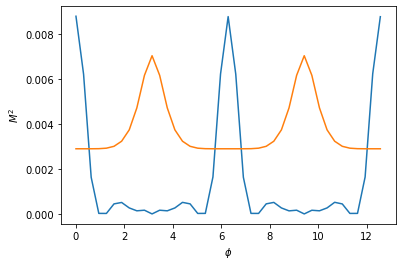

In [116]:
#pt_index_array1 = [1]*9+[0]+[1]*2+[2]*17+[1]+[2]+[0]+[1]*9
#pt_index_array2 = [2]*9+[1]+[2]+[0]+[1]*17+[0]+[1]*2+[2]*9
#pt_index_arrayd = [2]*9+[1]*2+[0]+[1]*17+[0]+[1]*2+[2]*9

pt_index_array1 = [0]*5+[1]*11+[0]*9+[1]*11+[0]*5
pt_index_array2 = [1]*5+[2]*11+[1]*9+[2]*11+[1]*5
pt_index_arrayd1 = [0]*5+[1]*11+[0]*9+[1]*11+[0]*5
pt_index_arrayd2 = [1]*5+[2]*11+[1]*9+[2]*11+[1]*5

M_squared = transition_element_squared_phi(psi_array6, psi_array6, psi_array6dif, pt_index_array1, pt_index_array2, pt_index_arrayd1, pt_index_arrayd2, 1e-3, B=0.05, W=100., mu=132.3363682761002+0.2, eta=0., L_A=100., a=6.0583)
print(M_squared)

Delta6 = band_gap(B=0.05, W=100, mu=132.3363682761002+0.2, eta=0., L_A=100.)

M_num_squared_array = []
for i in range(len(e_array6)):
    M_sqaured_num = numerical_M_squared_short(np.min(np.abs(e_array6[i])), tau=tau6[0], delta=Delta6)
    M_num_squared_array.append(M_sqaured_num)
    
print(M_num_squared_array)
                                             
plt.plot(np.linspace(0, 4*np.pi, 41), M_squared)
plt.plot(np.linspace(0, 4*np.pi, 41), M_num_squared_array)
#plt.ylim(-1e-5, 1e-3)
plt.xlabel(r'$\phi$')
plt.ylabel(r'$M^2$')

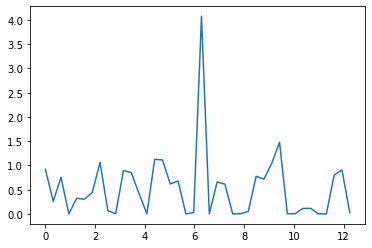

In [336]:
M_squared = transition_element_squared_phi(psi_array4, pt_index_array)
plt.plot(np.linspace(0, 4*np.pi, 41)[0:-1], M_squared)

In [260]:
print(np.abs(matrix_element(psi_array4[3][:,2], psi_array4[4][:,2], np.pi/10.))**2.)

0.4088094422096552


In [246]:
print(psi_array4[0][:,2].shape)

(488,)


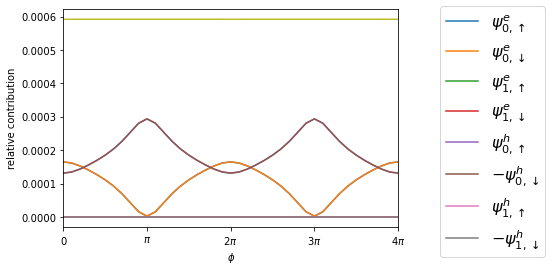

In [290]:
contribution_phi_plot(np.array(orbital_probs_array6))
total_prob(np.array(orbital_probs_array6))
plt.savefig('./subband transition/vanilla 6 lower branch contri', bbox_inches='tight', dpi=300)

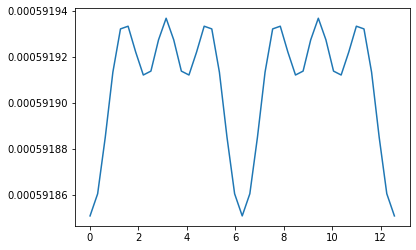

In [288]:
total_prob(orbital_probs_array6)

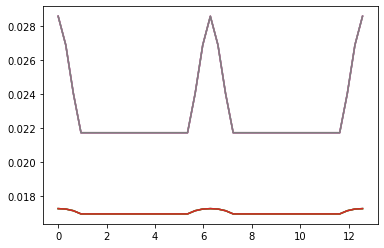

In [163]:
#plt.plot(phi_selected, np.array(orbital_probs_array))

Parameters: L, t, E_plus, E_minus, eta, nu, B
[2, 45.13293228464011, 198.78167562547094, -66.26055854182366, 0.0, 2.8885991119621015, 0.05]
41


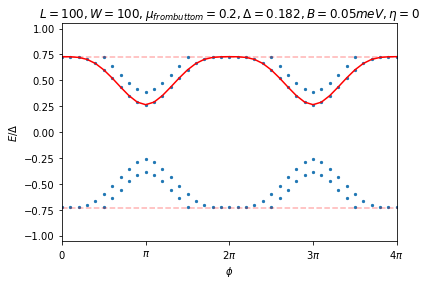

In [16]:
phi_plot(e_array6dif, 'vanilla 6 draft', title=r'$L=100, W=100, \mu_{from buttom}=0.2, \Delta=0.182, B=0.05meV, \eta=0$', gap_energy1 = band_gap(B=0.05, W=100, mu=132.3363682761002+0.2, eta=0., L_A=100.))
#plt.ylim(-0.25, 0.25)
#1
pt_index_array = [0]*5+[1]*11+[0]*9+[1]*11+[0]*5
pt_index_array = [1]*5+[2]*11+[1]*9+[2]*11+[1]*5
print(len(pt_index_array))
#pt_index_array = [1]*30 + [2]*7 + [1]*3+[2]
plt.plot(np.linspace(0, 4.*np.pi, 41), np.array([e_array6[i][pt_index_array[i]] for i in range(41)])/0.182, color='r')

In [27]:
print(e_array6[0])
print(Delta6)
print(numerical_M_squared_short(np.min(np.abs(e_array6[0])), Delta6, tau6))
print(Delta6/np.min(np.abs(e_array6[0]))-np.min(np.abs(e_array6[0]))/Delta6)

[-0.13253906  0.13253906]
0.13263789002076432
[0.00289352]
0.001490819167326407


Parameters: L, t, E_plus, E_minus, eta, nu, B
[2, 45.13293228464011, 198.78167562547094, -66.26055854182366, 0.0, 2.8885991119621015, 0.05]
[0.83552847]
[[0.01037396]]


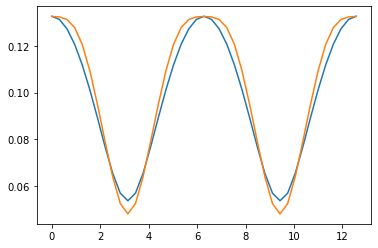

In [15]:
pt_index_array = [1]*5+[2]*11+[1]*9+[2]*11+[1]*5
Delta = band_gap(B=0.05, W=100, mu=132.3363682761002+0.2, eta=0., L_A=100.)

def E_A_analytic(phi, tau):
    return Delta*np.sqrt(1.-tau*np.sin(phi/2.)**2.)

tau6, tau6cov = op.curve_fit(E_A_analytic, np.linspace(0, 4*np.pi, 41), [e_array6[i][pt_index_array[i]] for i in range(41)], p0=[0.8])
print(tau6)
print(np.sqrt(tau6cov))

plt.plot(np.linspace(0, 4*np.pi, 41), E_A_analytic(np.linspace(0, 4*np.pi, 41), tau6))
plt.plot(np.linspace(0, 4*np.pi, 41), [e_array6[i][pt_index_array[i]] for i in range(41)])

In [71]:
print(psi_trial[:,0])
print(psi_array6[0][:,0])
print(-1j*np.log(psi_array6[0][:,0]/psi_trial[:,0]))

[ 2.32288989e-03+1.58513515e-03j  2.80012292e-03+1.91079796e-03j
  1.10374370e-17+7.33986833e-18j  1.27443408e-17+1.73839950e-17j
 -2.07438391e-03-1.41555519e-03j -2.49015540e-03-1.69927678e-03j
  9.07163117e-18-1.21083453e-17j -2.49661688e-17-4.25450886e-18j
  2.35481047e-03+1.60691768e-03j  2.77250228e-03+1.89194969e-03j
  1.88062978e-17+3.52026282e-17j  9.56326329e-18+1.27981708e-17j
 -2.10351140e-03-1.43543173e-03j -2.46752542e-03-1.68383413e-03j
 -1.56667648e-17-9.41241953e-20j  1.80143753e-17-6.61605770e-18j
  2.38646742e-03+1.62852032e-03j  2.74457286e-03+1.87289071e-03j
  4.09637390e-17+5.51121014e-18j  1.12229684e-17-5.63041621e-18j
 -2.13224998e-03-1.45504287e-03j -2.44442098e-03-1.66806770e-03j
  1.31259609e-17+8.60382625e-18j  1.77856045e-17+2.02648080e-17j
  2.41785734e-03+1.64994073e-03j  2.71633769e-03+1.85362310e-03j
  7.49962794e-18-7.23202730e-18j  2.23828718e-19+5.87186182e-18j
 -2.16059290e-03-1.47438402e-03j -2.42084753e-03-1.65198124e-03j
 -1.07259866e-17-8.924762

In [140]:
syst = make_system_mixed(L_A=100., W=100., mu=132.3363682761002+0.2, B=0.05, phi=0., eta=0.)
print(syst.hamiltonian_submatrix().shape)
#print(psi_array6[0][:,0])
#print((syst.hamiltonian_submatrix()@psi_array6[0][:,0])/psi_array6[0][:,0])
mat, norbs = syst.hamiltonian_submatrix(return_norb=True)[:2]
tot_norbs = sum(norbs)
print(tot_norbs)

'''for leadnum, interface in enumerate(syst.lead_interfaces):
    lead = syst.leads[leadnum]
    _, stab = lead.modes(e_array6[0][0])
    evan_vecs = slice(2 * stab.nmodes, None)
    u_out = stab.vecs[:, evan_vecs]
    u_out_over_lmbda = stab.vecslmbdainv[:, evan_vecs]
    #print(lead.inter_cell_hopping())
    #print(evan_vecs)
    #print(u_out)
    #print(u_out/u_out_over_lmbda)'''
    
print(e_array6[0][1])
evan_basis0 = syst.leads[0].modes(e_array6[0][1])[1].vecs
evan_basis0overlambda = syst.leads[1].modes(e_array6[0][1])[1].vecslmbdainv
print('evan_basis0')
print(evan_basis0.shape)
print('evan_basis0overlambda')
print(evan_basis0overlambda.shape)
print('nmodes')
print(syst.leads[0].modes(e_array6[0][1])[1].nmodes)
eigenvalues = evan_basis0/evan_basis0overlambda
print('eigenvalues')
print(eigenvalues)
    
#trial_wavefunc = kwant.solvers.default.wave_function(syst, 0.182)
#print(trial_wavefunc(1))

#effective_H = make_linsys(syst, e_array6[0][0])
#print(effective_H)
temp_vec = extract_boundstates(syst, e_array6[0][0])
#e_trial, psi_trial = find_boundstates(syst, -1.1*0.182, 1.1*0.182, rtol=1e-2*0.182)
#print(temp_vec[0:136])
#print(psi_array6[0][:,0])
#print(temp_vec[:tot_norbs, :].flatten())
#print(-1j*np.log(temp_vec[:tot_norbs, :].flatten()/psi_array6[0][:,0]))

Parameters: L, t, E_plus, E_minus, eta, nu, B
[17, 4513.29322846401, 198.78167562547094, -66.26055854182366, 0.0, 28.885991119621014, 0.05]
(136, 136)
136
0.13253905731633014
evan_basis0
(8, 8)
evan_basis0overlambda
(8, 8)
nmodes
0
eigenvalues
[[ 4.75324350e-01+0.j  2.40003187e-01-0.j  6.87600075e-03-0.j
  -8.73001131e+01+0.j  8.00000000e+00+0.j  4.80000000e+00+0.j
   8.00000000e+00+0.j  5.71428571e+00+0.j]
 [ 2.63209071e-01-0.j  5.21337990e-01-0.j  1.40193780e+01-0.j
  -4.24000662e-03+0.j  3.33333333e-01+0.j -3.90625000e-01+0.j
  -3.20000000e-01+0.j  1.36986301e-01+0.j]
 [ 1.34771806e-01+0.j  2.38827962e-01+0.j  4.80569253e+00+0.j
   1.53431589e-02-0.j  2.95553964e-01+0.j -2.97487885e-01+0.j
  -3.00508783e-01+0.j -2.98513112e-01+0.j]
 [-3.01608949e-01+0.j  4.05839201e-01+0.j  1.47604958e-01+0.j
  -3.15845940e-01+0.j -2.98490654e-01+0.j  3.00315885e-01-0.j
   2.97523721e-01+0.j  2.95673710e-01-0.j]
 [ 2.19080121e+00-0.j  3.84751614e-02-0.j  3.31545099e-01+0.j
   3.80451722e-01-0.j  5.4

In [175]:
syst = make_system_mixed(L_A=100., W=100., mu=132.3363682761002+0.2, B=0.05, phi=0., eta=0.)

en=0.2
print(en)
evan_basis0 = syst.leads[0].modes(en)[1].vecs
evan_basis0overlambda = syst.leads[1].modes(en)[1].vecslmbdainv
eigenvalues = np.divide(evan_basis0, evan_basis0overlambda)
print('evan_basis0')
print(evan_basis0)
print('evan_basis0overlambda')
print(evan_basis0overlambda)
print('number of prop modes')
print('eigenvalues')
print(eigenvalues)
print('size of lambdas')
print(np.abs(eigenvalues))
print('test 1/sqrt(number of orbitals)')
print(1./np.sqrt(8.))
print('1 over size of lambdas')
print(1./np.abs(eigenvalues))
print('phase of the lambdas, or k')
print(np.angle(eigenvalues))
print('number of prop modes')
print(syst.leads[1].modes(en)[1].nmodes)
print('prop wavefunctions')
print(syst.leads[0].modes(en)[0].wave_functions)
print('momenta')
print(syst.leads[0].modes(en)[0].momenta)
print('vel')
print(syst.leads[0].modes(en)[0].velocities)

Parameters: L, t, E_plus, E_minus, eta, nu, B
[17, 4513.29322846401, 198.78167562547094, -66.26055854182366, 0.0, 28.885991119621014, 0.05]
0.2
evan_basis0
[[ 3.15104441e+00-2.98180988e+00j  2.84833968e+00+8.51877691e-01j
   2.31678712e+00-2.57110359e+00j  3.15104441e+00+2.98180988e+00j
   2.84833968e+00-8.51877691e-01j  2.31678712e+00+2.57110359e+00j
   1.37084950e-01+0.00000000e+00j  3.88578059e-15+0.00000000e+00j
   1.38777878e-15+0.00000000e+00j  2.58126853e-15+0.00000000e+00j
  -3.88578059e-16+0.00000000e+00j]
 [-3.18600623e+00-2.93887138e+00j -2.80810319e+00+8.76141902e-01j
   2.29354216e+00+2.58526684e+00j -3.18600623e+00+2.93887138e+00j
  -2.80810319e+00-8.76141902e-01j  2.29354216e+00-2.58526684e+00j
   1.66895788e-01+0.00000000e+00j  6.91113833e-15+0.00000000e+00j
  -7.28583860e-16+0.00000000e+00j -1.33226763e-15+0.00000000e+00j
   2.44249065e-15+0.00000000e+00j]
 [-1.04146839e-14-9.07059274e-15j -8.96003811e-15+2.90959272e-15j
   7.08406774e-15+8.46914657e-15j -1.04146839e-1

In [169]:
print('evan_basis0')
print(evan_basis0[:,:6])
print('prop wavefunctions')
print(syst.leads[0].modes(en)[0].wave_functions)
print('division')
print(np.divide(evan_basis0[:,:6], syst.leads[0].modes(en)[0].wave_functions))
#print(np.sum(np.abs(syst.leads[0].modes(en)[0].wave_functions), axis=0))

evan_basis0
[[ 3.15104441e+00-2.98180988e+00j  2.84833968e+00+8.51877691e-01j
   2.31678712e+00-2.57110359e+00j  3.15104441e+00+2.98180988e+00j
   2.84833968e+00-8.51877691e-01j  2.31678712e+00+2.57110359e+00j]
 [-3.18600623e+00-2.93887138e+00j -2.80810319e+00+8.76141902e-01j
   2.29354216e+00+2.58526684e+00j -3.18600623e+00+2.93887138e+00j
  -2.80810319e+00-8.76141902e-01j  2.29354216e+00-2.58526684e+00j]
 [-1.04146839e-14-9.07059274e-15j -8.96003811e-15+2.90959272e-15j
   7.08406774e-15+8.46914657e-15j -1.04146839e-14+9.07059274e-15j
  -8.96003811e-15-2.90959272e-15j  7.08406774e-15-8.46914657e-15j]
 [ 9.94855336e-16-5.44949577e-15j  1.40498508e-15-4.82698619e-15j
   1.07724079e-14-2.02217755e-15j  9.94855336e-16+5.44949577e-15j
   1.40498508e-15+4.82698619e-15j  1.07724079e-14+2.02217755e-15j]
 [-1.90948693e+00+2.01598194e+00j -2.93266651e+00+1.71668612e+00j
  -3.95273965e+00+3.69354148e+00j -1.90948693e+00-2.01598194e+00j
  -2.93266651e+00-1.71668612e+00j -3.95273965e+00-3.69354148

In [211]:
print(psi_array5prime[0][:,0][0:4]*np.exp(-1j*np.angle(psi_array5prime[0][:,0][0])))
print(psi_array5prime[1][:,0][0:4]*np.exp(-1j*np.angle(psi_array5prime[1][:,0][0])))

[ 3.55861007e-02+0.00000000e+00j  7.21596534e-04-1.08420217e-19j
 -8.61497609e-19+1.65223167e-18j -2.92073616e-18+1.71984405e-18j]
[3.55696646e-02-8.67361738e-19j 3.70093327e-04-8.15201224e-03j
 1.26527305e-18-1.63834056e-19j 5.40919430e-19-9.29560333e-20j]


In [52]:
print(e_array4dif[9])
print(e_array4[9])

[-0.010727  0.010727]
[-0.01076122  0.01076122]


In [149]:
e_array4res
print(pt_index_array)

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 1, 1, 1, 2]


In [162]:
def orbital_probs_array_gen(pt_index_array, psi_array, fig_title, suptitle=r'$L=3700, W=1e9, \mu=0.887, \Delta=0.182, B=1.2meV, $', size=61):
    phi_array = np.linspace(0., 4*np.pi, 41)
    orbital_probs_array = []
    for i in range(41):
        orbital_probs_1 = wavefunc_visualiser(psi_array[i], pt_index_array[i], size=size)
        plt.suptitle(suptitle+r'$\phi=%.2f$' % phi_array[i], fontsize=20)
        plt.savefig(fig_title+'/phi_loc=%i' % i, dpi=300)
        orbital_probs_array.append(orbital_probs_1)
    #print(orbital_probs_1)
    print(orbital_probs_array)
    return orbital_probs_array

In [ ]:
orbital_probs_array6 = orbital_probs_array_gen([0]*5+[1]*11+[0]*9+[1]*11+[0]*5, psi_array6, './subband transition/wavefuncs/vanilla 6 lower branch/', suptitle=r'$L=100, W=100, \mu_{buttom}=0.2, \Delta=0.182, B=0.05meV, $', size=17)

In [117]:
#print(psi_array4res[-2][:,1])
'''print(psi_array4res[-5][:,1][0])
print(psi_array4res[-5][:,2][0])
print(psi_array4res[-1][:,2][0])'''

A = np.array([[psi_array4res[-5][:,1][0], psi_array4res[-5][:,2][0]],
             [psi_array4res[-5][:,1][1], psi_array4res[-5][:,2][1]]])
B = np.array([[psi_array4res[-1][:,2][0]],
             [psi_array4res[-1][:,2][1]]])
B_lower = np.array([[psi_array4res[-1][:,1][0]],
             [psi_array4res[-1][:,1][1]]])
B_andr = np.array([[psi_array4res[-1][:,3][0]],
             [psi_array4res[-1][:,3][1]]])
X = np.linalg.inv(A).dot(B)
X_lower = np.linalg.inv(A).dot(B_lower)
X_andr = np.linalg.inv(A).dot(B_andr)
print(X)
print(X_lower)
print(X_andr)

print(np.abs(X)**2.)
print(np.abs(X_lower)**2.)
print(np.abs(X_andr)**2.)

[[ 0.02392851+0.85669946j]
 [-0.70612581+0.47587476j]]
[[-0.21595016-0.56820982j]
 [-0.41091527+0.47262261j]]
[[1.3164228 +0.31690412j]
 [0.53851278+1.25034056j]]
[[0.73450654]
 [0.72507044]]
[[0.36949687]
 [0.39222349]]
[[1.83339722]
 [1.85334753]]


In [125]:
psi_4_pi_pt_mbs0 = psi_array4res[-1][:,1]
psi_4_pi_pt_mbs1 = psi_array4res[-1][:,2]
inverse_transformation = np.array([X_lower.flatten(), X.flatten()])
print(np.abs(np.linalg.det(np.linalg.inv(inverse_transformation))))
print(np.sum(np.abs(np.linalg.inv(inverse_transformation))**2., axis=1))
phi_4_pi_pts = []

for i in range(len(psi_4_pi_pt_mbs0)):
    mbs_solns = np.array([[psi_4_pi_pt_mbs0[i]],
                         [psi_4_pi_pt_mbs1[i]]])
    phi_4_pi_pts.append(np.linalg.inv(inverse_transformation).dot(mbs_solns).flatten())
phi_4_pi_pts = np.array(phi_4_pi_pts)
#print(phi_4_pi_pts[:,0])

0.949093194404984
[1.00643368 0.99446187]


In [ ]:
C_prime_array = []
for i in range(len(psi_array4res[-5][:,1])):
    C_prime = psi_array4res[-5][:,1][i]*X_andr[0]+psi_array4res[-5][:,2][i]*X_andr[1]
    C_prime_array.append(C_prime)
C_prime_array = np.array(C_prime_array)
print(C_prime_array.flatten()-psi_array4res[-1][:,3])
#print(psi_array4res[-1][:,3])

In [ ]:
orbital_probs_array4res = orbital_probs_array_gen(pt_index_array, psi_array4res, './subband transition/wavefuncs/vanilla 4 branch 1 res', suptitle=r'$L=3700, W=10, \mu=0.422+bottom, \Delta=0.182, B=0.574meV, $')

In [205]:
print(psi_array3[0].shape)
print(e_array3[10])

(488, 4)
[-1.24175038e-02  2.02771157e-11  2.02771157e-11  1.24175038e-02]


0.018858375203930165
0.018858375204093274
1.5216260813445677e-35
9.791529238009793e-36
0.014013496294520356
0.014013496294620141
1.5793139763640363e-35
7.269292975187224e-36
0.06574374299716394


Text(0.5, 0.98, '$L=1000, W=10, \\mu_{buttom}=0.422, \\Delta=0.182, B=0.574meV, \\phi=0$')

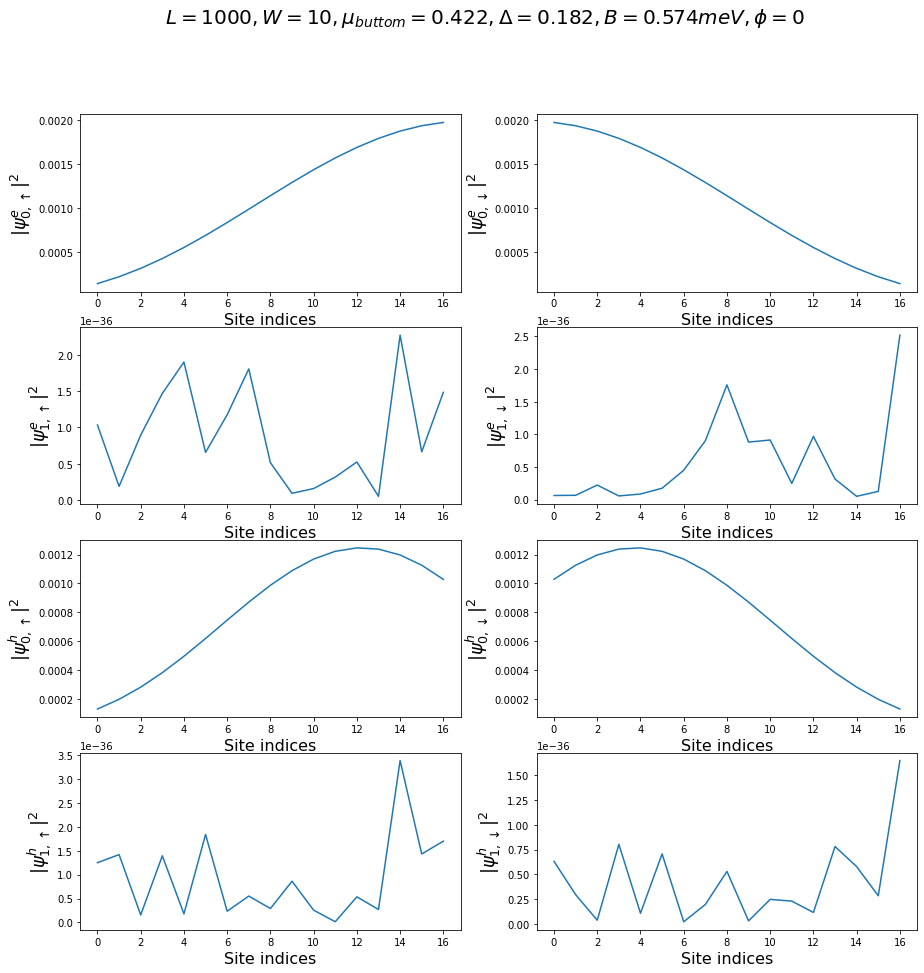

In [207]:
orbital_probs_1 = wavefunc_visualiser(psi_array5prime[0], 1, size=17)
plt.suptitle(r'$L=1000, W=10, \mu_{buttom}=0.422, \Delta=0.182, B=0.574meV, \phi=0$', fontsize=20)
#plt.savefig('./subband transition/wavefuncs/vanilla 5/phi=0 higher abs2', dpi=300)

In [ ]:
phi_array = np.linspace(0, 4.*np.pi, 41)
phi_selected = []
orbital_probs_array = []
for i in range(41):
    if len(psi_array4[i][0])==4:
        orbital_probs_1 = wavefunc_visualiser(psi_array4[i], 3)
        plt.suptitle(r'$L=3700, W=1e9, \mu=0.887, \Delta=0.182, B=1.2meV, \phi=%.2f$' % phi_array[i], fontsize=20)
        plt.savefig('./subband transition/wavefuncs/vanilla 1 higher andreev/phi_loc=%i' % i, dpi=300)
        phi_selected.append(phi_array[i])
        orbital_probs_array.append(orbital_probs_1)
print(orbital_probs_array)

In [ ]:
#print(orbital_probs_array_branch_1)
#print(orbital_probs_array_branch_2)

In [60]:
print(psi_array1[0].shape)

(488, 4)


In [ ]:
#vanilla 1: Keselman, no (actually degenerate) subbands, tp regime wavefunction
e_array1, psi_array1 = phi_scan(W=1e9, B=1.2)

In [ ]:
#vanilla 2: Multiple subbands but with no mixing (eta=0), not physical, but wants to isolate the effect of the mixing parameter
e_array2, psi_array2 = phi_scan(B=0.574, eta=0.)

In [ ]:
#case 3: wavefunc of subband mixed states (eta~0.35).
e_array3, psi_array3 = phi_scan(B=0.574)

In [ ]:
#vanilla 4: W=0, subbands very far apart, strong mixing(?)
e_array4, psi_array4 = phi_scan(B=0.574, W=10, mu=13251.741972368807+0.422)

In [ ]:
e_array4res, psi_array4res = phi_scan(B=0.574, W=10, mu=13251.741972368807+0.422, phi_array=[np.pi*9./10., np.pi])

In [ ]:
e_array4dif, psi_array4dif = phi_scan(B=0.574, W=10, mu=13251.741972368807+0.422, phi_array=[1e-3, 4*np.pi+1e-3])

In [130]:
import pickle
e_array4 = pickle.load(open('./subband transition/data/e_array4', 'rb'))
psi_array4 = pickle.load(open('./subband transition/data/psi_array4', 'rb'))
e_array4res = pickle.load(open('./subband transition/data/e_array4res', 'rb'))
psi_array4res = pickle.load(open('./subband transition/data/psi_array4res', 'rb'))
e_array4dif = pickle.load(open('./subband transition/data/e_array4dif', 'rb'))
psi_array4dif = pickle.load(open('./subband transition/data/psi_array4dif', 'rb'))
#print(e_array4)
print(psi_array4[40])

[[-1.57490544e-02+5.86812810e-03j  4.21377916e-04+7.86791248e-04j
  -1.40031592e-02-1.11404606e-02j -7.84403090e-03+7.80049350e-04j]
 [ 3.02826186e-02-1.12833622e-02j -5.01843323e-03-9.37035186e-03j
   3.29558822e-02+2.62186341e-02j  4.06525932e-02-4.04269557e-03j]
 [-4.21597926e-05-1.13149689e-04j -3.49987612e-05+1.87441143e-05j
   9.79566861e-05-1.23128039e-04j -1.51010964e-05-1.51853811e-04j]
 ...
 [-3.82820575e-02+1.42639685e-02j  1.98823684e-02+3.71240942e-02j
   8.31826927e-03+6.61774601e-03j  3.21578060e-02-3.19793178e-03j]
 [ 5.32816682e-05+1.42998905e-04j  1.38701095e-04-7.42834626e-05j
   2.47176324e-05-3.10691770e-05j -1.19489332e-05-1.20156245e-04j]
 [ 1.02335125e-05+2.74650013e-05j  5.87950114e-05-3.14885549e-05j
   2.05404172e-06-2.58185674e-06j -6.20127457e-06-6.23588614e-05j]]


In [ ]:
#vanilla 5: W=0, subbands very far apart, no mixing, B=0
e_array5, psi_array5 = phi_scan(B=0., W=10, mu=13251.741972368807+0.422, eta=0., L_A=1000.)

In [ ]:
#vanilla 5^prime: W=10, subbands very far apart, no mixing, B=0.05 to avoid spin degeneracy, mu=0.2 to be always in the single channel regime
e_array5prime, psi_array5prime = phi_scan(B=0.05, W=10, mu=13251.92683565613+0.2, eta=0., L_A=1000.)

In [ ]:
e_array5primediff, psi_array5primediff = phi_scan(B=0.05, W=10, mu=13251.92683565613+0.2, eta=0., L_A=1000., phi_array=[1e-3, 4*np.pi+1e-3])

In [ ]:
#vanilla 6:
e_array6, psi_array6 = phi_scan(B=0.05, W=100., mu=132.3363682761002+0.2, eta=0., L_A=100., a=6.0583)

In [ ]:
e_array6dif, psi_array6dif = phi_scan(B=0.05, W=100., mu=132.3363682761002+0.2, eta=0., L_A=100., a=6.0583, phi_array=[1e-3, 4*np.pi+1e-3])

In [7]:
import pickle
e_array6 = pickle.load(open('./subband transition/data/e_array6', 'rb'))
psi_array6 = pickle.load(open('./subband transition/data/psi_array6', 'rb'))
e_array6dif = pickle.load(open('./subband transition/data/e_array6dif', 'rb'))
psi_array6dif = pickle.load(open('./subband transition/data/psi_array6dif', 'rb'))
#print(e_array4)
print(psi_array6[40].shape)

(136, 2)


In [ ]:
print(e_array4)
print('---')
print(e_array4dif)

In [105]:
#syst = make_system_mixed(W=10, mu=13251.741972368807+0.422, B=0.574, phi=np.pi/10.*0, B=0.182, W=100., mu=132.3363682761002+0.2, eta=0., L_A=100.*10)
trial = np.array(psi_array4[0][:,1]).T.conj()@syst.hamiltonian_submatrix()@np.array(psi_array4[0][:,1])
print(trial)
print(e_array4[0][1])

Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 19878.1675625471, -6626.055854182365, 49.49747468305833, 2.8885991119621015, 0.574]
(-0.18290522497318362+1.249000902703301e-16j)
-0.09349181174714903


In [ ]:
print(psi_array4[0][:,1][0:4])
print(psi_array4[0][:,2][0:4])
print(np.array(psi_array4[0][:,1]).T.conj().dot(np.array(psi_array4[0][:,2])))
print(np.array(psi_array4[0][:,1]).T.conj().dot(np.array(psi_array4[0][:,1])))

def mat_ele_diagonal_percentage_diff(e_array, psi_array):
    thing = []
    for i in range(len(e_array)):
        syst = make_system_mixed(B=0.05, W=10, mu=13251.92683565613+0.2, eta=0., L_A=1000., phi=np.pi/10.*i, a=6.0583*10)
        thing.append((np.array(psi_array[i][:,1]).T.conj()@syst.hamiltonian_submatrix()@np.array(psi_array[i][:,1])-e_array[i][1])/e_array[i][1])
    return thing

def mat_ele_diff(e_array, psi_array):
    thing = []
    for i in range(len(e_array)):
        syst = make_system_mixed(B=0.05, W=10, mu=13251.92683565613+0.2, eta=0., L_A=1000., phi=np.pi/10.*i, a=6.0583*10)
        thing.append(np.array(psi_array[i][:,1]).T.conj()@syst.hamiltonian_submatrix()@np.array(psi_array[i][:,1])-e_array[i][1])
    return thing

def mat_ele(e_array, psi_array):
    thing = []a=6.
    for i in range(len(e_array)):
        syst = make_system_mixed(B=0.05, W=10, mu=13251.92683565613+0.2, eta=0., L_A=1000., phi=np.pi/10.*i, a=6.0583*10)
        thing.append(np.array(psi_array[i][:,2]).T.conj()@syst.hamiltonian_submatrix()@np.array(psi_array[i][:,2]))
    return thing
        
percentage_diff = np.array(mat_ele_diagonal_percentage_diff(e_array5prime, psi_array5prime))
abs_diff = np.array(mat_ele_diff(e_array5prime, psi_array5prime))
mat_ele_calc = np.array(mat_ele(e_array5prime, psi_array5prime))
print(mat_ele_calc)

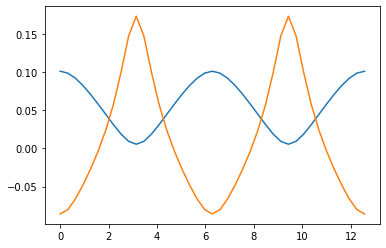

In [227]:
#plt.plot(np.linspace(0, 4*np.pi, 41), np.real(percentage_diff)*100.)
#plt.xlabel(r'$\phi$')
#plt.ylabel('Percentage Difference')
#plt.plot(np.linspace(0, 4*np.pi, 41), np.real(abs_diff))
plt.plot(np.linspace(0, 4*np.pi, 41), [e_array5prime[i][2] for i in range(41)])
plt.plot(np.linspace(0, 4*np.pi, 41), np.real(mat_ele_calc))

In [266]:
incre = 1e-3
print(incre)
syst = make_system_mixed(W=10, mu=13251.741972368807+0.422, B=0.574, phi=incre)
energies, wavefunctions = find_boundstates(syst, -1.1*0.182, 1.1*0.182, rtol=1e-2*0.182)


0.001
Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 19878.1675625471, -6626.055854182365, 49.49747468305833, 28.885991119621014, 0.574]


In [267]:
syst0 = make_system_mixed(W=10, mu=13251.741972368807+0.422, B=0.574, phi=0.)
energies0, wavefunctions0 = find_boundstates(syst0, -1.1*0.182, 1.1*0.182, rtol=1e-2*0.182)

Parameters: L, t, E_plus, E_minus, eta, nu, B
[611, 4513.29322846401, 19878.1675625471, -6626.055854182365, 49.49747468305833, 28.885991119621014, 0.574]


In [268]:
print(energies)
print(energies0)

[-0.11035627 -0.09734701  0.09734701  0.11035627]
[-0.11035621 -0.09734708  0.09734708  0.11035621]


In [284]:
print(energies_smol)
print(energies_smol0)

[-0.11673768 -0.09349177  0.09349177  0.11673768]
[-0.11673764 -0.09349181  0.09349181  0.11673764]


In [278]:
print(wavefunctions[:,1].shape)
print(wavefunctions0[:,1].shape)

(4888,)
(4888,)


In [282]:
syst_smol = make_system_mixed(W=10, mu=13251.741972368807+0.422, B=0.574, phi=incre, a=6.0583*10)
energies_smol, wavefunctions_smol = find_boundstates(syst_smol, -1.1*0.182, 1.1*0.182, rtol=1e-2*0.182)

Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 19878.1675625471, -6626.055854182365, 49.49747468305833, 2.8885991119621015, 0.574]


In [283]:
syst_smol0 = make_system_mixed(W=10, mu=13251.741972368807+0.422, B=0.574, phi=0., a=6.0583*10)
energies_smol0, wavefunctions_smol0 = find_boundstates(syst_smol0, -1.1*0.182, 1.1*0.182, rtol=1e-2*0.182)

Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 19878.1675625471, -6626.055854182365, 49.49747468305833, 2.8885991119621015, 0.574]


In [280]:
print(wavefunctions[:,1]-wavefunctions0[:,1])

[ 1.52745601e-04-3.53509305e-04j -5.76585238e-04+1.34849434e-03j
  5.04384349e-06+2.15666550e-06j ...  1.26803267e-03-2.98076902e-03j
 -1.11617564e-05-4.74821656e-06j -5.08217386e-06-2.15400055e-06j]


In [286]:
print((wavefunctions_smol[:,1]-wavefunctions_smol0[:,1]).shape)

(488,)


In [288]:
print(np.abs(matrix_element(wavefunctions0[:,1], wavefunctions[:,1], incre))**2.)
print(np.abs(matrix_element(wavefunctions_smol0[:,1], wavefunctions_smol[:,1], incre))**2.)

1908.5798886077691
3125.733652009201


In [339]:
def matrix_element_diff(incre):
    syst0 = make_system_mixed(W=10, mu=13251.741972368807+0.422, B=0.574, phi=0., a=6.0583*10)
    syst1 = make_system_mixed(W=10, mu=13251.741972368807+0.422, B=0.574, phi=incre, a=6.0583*10)
    
    e0, psi0 = find_boundstates(syst0, -1.1*0.182, 1.1*0.182, rtol=1e-2*0.182)
    e1, psi1 = find_boundstates(syst1, -1.1*0.182, 1.1*0.182, rtol=1e-2*0.182)
    return np.abs(matrix_element(psi0[:,1], psi1[:,1], incre))**2.

In [340]:
mat_ele_vs_incre = []
for i in np.arange(0, 7):
    mat_ele_vs_incre.append(matrix_element_diff(10.**(-i)))
print(mat_ele_vs_incre)

Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 19878.1675625471, -6626.055854182365, 49.49747468305833, 2.8885991119621015, 0.574]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 19878.1675625471, -6626.055854182365, 49.49747468305833, 2.8885991119621015, 0.574]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 19878.1675625471, -6626.055854182365, 49.49747468305833, 2.8885991119621015, 0.574]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 19878.1675625471, -6626.055854182365, 49.49747468305833, 2.8885991119621015, 0.574]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 19878.1675625471, -6626.055854182365, 49.49747468305833, 2.8885991119621015, 0.574]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 19878.1675625471, -6626.055854182365, 49.49747468305833, 2.8885991119621015, 0.574]
Parameters: L, t, E_plus, E_minus, eta, nu, B
[61, 45.13293228464011, 19878.

In [314]:
import pickle
pickle.dump(psi_array5primediff, open('./subband transition/data/psi_array5primediff', 'wb'))

In [341]:
mat_ele_vs_incre = np.array(mat_ele_vs_incre)
mat_ele_vs_incre*(np.array([10.**(-i) for i in range(0, 7)])**2.)

array([3.33155976e-01, 4.02284905e-01, 2.40407629e-05, 6.86072837e-09,
       6.99448360e-13, 6.99910432e-17, 7.24136166e-21])

In [ ]:
#print(wavefunctions_smol0[:,1])
#print(wavefunctions_smol[:,1])
print(wavefunctions_smol[:,1]-wavefunctions_smol0[:,1])

In [ ]:
syst0 = make_system_mixed(W=10, mu=13251.741972368807+0.422, B=0.574, phi=0., a=6.0583*10)
syst1 = make_system_mixed(W=10, mu=13251.741972368807+0.422, B=0.574, phi=1e-7, a=6.0583*10)

e0, psi0 = find_boundstates(syst0, -1.1*0.182, 1.1*0.182, rtol=1e-2*0.182)
e1, psi1 = find_boundstates(syst1, -1.1*0.182, 1.1*0.182, rtol=1e-2*0.182)
#return np.abs(matrix_element(psi0[:,1], psi1[:,1], incre))**2.

In [ ]:
syst19 = make_system_mixed(W=10, mu=13251.741972368807+0.422, B=0.574, phi=1e-9, a=6.0583*10)
e19, psi19 = find_boundstates(syst19, -1.1*0.182, 1.1*0.182, rtol=1e-2*0.182)
#return np.abs(matrix_element(psi0[:,1], psi1[:,1], incre))**2.

In [333]:
print(e0)
print(e1)
print(e19)
print('psi0')
print(psi0[:,1][0:4])
print('psi1')
print(psi1[:,1][0:4])
print('psi19')
print(psi19[:,1][0:4])
print('psi1-psi0')
print(psi1[:,1][0:4]-psi0[:,1][0:4])
print('psi19-psi0')
print(psi19[:,1][0:4]-psi0[:,1][0:4])
print(np.abs(psi0[:,1][0:4])**2.)
print(np.abs(psi1[:,1][0:4])**2.)
print(np.abs(psi19[:,1][0:4])**2.)
print(np.average(np.log(psi1[:,1]/psi0[:,1])/1j))
print(np.average(np.log(psi19[:,1]/psi0[:,1])/1j))

[-0.11673764 -0.09349181  0.09349181  0.11673764]
[-0.11673764 -0.09349181  0.09349181  0.11673764]
[-0.11673764 -0.09349181  0.09349181  0.11673764]
psi0
[ 4.05453620e-04+7.95114570e-04j -4.82878157e-03-9.46947911e-03j
 -3.53690067e-05+1.80357553e-05j  2.93917372e-06-1.49877598e-06j]
psi1
[ 7.34159024e-04+5.07553291e-04j -8.74354762e-03-6.04471183e-03j
 -2.25773193e-05+3.26576141e-05j  1.87619173e-06-2.71384896e-06j]
psi19
[ 2.60641961e-05+8.92143752e-04j -3.10413994e-04-1.06250557e-02j
 -3.96851467e-05+1.15941273e-06j  3.29784608e-06-9.63473719e-08j]
psi1-psi0
[ 3.28705405e-04-2.87561279e-04j -3.91476605e-03+3.42476728e-03j
  1.27916874e-05+1.46218588e-05j -1.06298199e-06-1.21507298e-06j]
psi19-psi0
[-3.79389424e-04+9.70291820e-05j  4.51836758e-03-1.15557662e-03j
 -4.31613996e-06-1.68763426e-05j  3.58672363e-07+1.40242861e-06j]
[7.96599817e-07 1.12988166e-04 1.57625511e-09 1.08850716e-11]
[7.96599816e-07 1.12988166e-04 1.57625511e-09 1.08850716e-11]
[7.96599816e-07 1.12988166e-04 1.5

In [313]:
print(np.array(e1)-np.array(e0))

[ 8.83737528e-14 -5.34100542e-13  1.50712776e-14 -3.81916720e-14]
